# Demo of MLP Library Usage

## INSTRUCTIONS

For more detailed instructions of using MLPLibrary consult the documentation. This demo will give practical demonstration of MLPLibrary functions and usage for constructing MLP models, setting hyperparameters and evaluating training and testing performance, using the provided data for COMP5329 Assignment 1. 

### Installing MLPLibrary

As provided in the README.md in the main folder, MLPlibrary may be installed locally as a portable library (similar to NumPy or PyTorch) simply by navigating into the network directory (i.e. ```'MLPLibrary/network/'```) and executing the following statement:
```
pip install ..
```
This will install all the required dependencies stated in the ```setup.py``` file and allow usage of our library functions anywhere on your device locally.

After this step, you may perform the following imports. If you decide not to install MLPLibrary, make sure you are within the main folder of MLPLibrary.

## IMPORTING MLPLibrary

In [1]:
# Importing all the modules and functions related to constructing MLP network models

from network.net import Net                   # Net class, base class for constructing MLP networks
from network.layer import Linear              # Linear class, child class of parent class Layer 
from network.loss import CrossEntropyLoss     # CrossEntropyLoss class, child class of parent class Loss
from network.activ import ReLU, LeakyReLU     # ReLU, LeakyReLU classes, child classes of parent class Activation
from network.optim import SGD, Adam           # SGD, Adam classes, child classes of parent class Optimizer

In [2]:
# Importing all the modules and functions related to data processing including loaders for the assignment data

# Process module contains functions relating to data processing:
from network.loader.process import (
    train_test_split,        # Function to split data with chosen ratio, data can be shuffled
    normalize,               # Normalizes data to have mean of zero and unit variance
    standardize,             # Normalizes data to be between range 0-1, i.e. standardizes data
    one_hot,                 # One hot encoding: 100% prob of 2 is [0, 0, 1] with 3 classes
    pca                      # Reduces data to chosen K principal components
) 

# Data module for loading the assignment data
from network.dataset.source import (
    get_data_from_file,   # Loads assignment data from file (must be within main directory)
    get_data_from_url     # Loads assignment data from public GitHub repo that stores data
)

# Data loader module for automating processing of and loading of assignment data based on parameter selections
from network.loader.data_loader import load_train_val_test  # Parameter selections decide method of processing                            

### Importing Standard Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd 
import seaborn as sns

# setting random seed
np.random.seed(123)

## Device and System Specifications

* Processor: AMD Ryzen 9 5900HX with Radeon Graphics 
* Installed RAM: 32.0 GB (31.4 GB usable)
* GPU: NVIDIA GeForce RTX 3080 (*flex*)
* OS: Windows 11 Home

Wall time:

### Data Loading and Preprocessing

#### Parameter Selections

The load_train_val_test function imported from the network.loader.data_loader module provides us the ability to decide the processing method we apply to the assignment training and testing data, if we apply PCA to transform this data, where we source this data (from file or internet), among others described below.

The following parameter selections are made for loading the train, validation and test data; and will be used for training and testing our constructed models.

In [4]:
SOURCE_DATA = "url"          # May choose from "url" or "file" to source assignment data (must be in main for "file")
NORM_METHOD = "standardize"  # May choose from "standardize", "normalize" or "none" (none is no normalization on data)
PCA_N_COMPONENTS = 0         # If PCA_N_COMPONENTS > 0;
                                # Normalization is skipped as done implicitly by mean centering prior to applying PCA
                                # Strictly, the choice of PCA_N_COMPONENTS <= N_DIMENSIONS of the input dataset 
N_CATEGORIES = 10            # If N_CATEGORIES > 0 chosen, then categorical one-hot encoding is applied to label data
SPLIT_RATIO = 0.2             # Ratio data is to be split upon when obtaining a train test split (default is set to 0.2)
SHUFFLE_DATA = True          # IF SHUFFLE is True, then the data is shuffled prior to splitting by taking random indices

#### Obtaining loaded and processed data based on the chosen parameter selections:

In [5]:
# Note as we are loading data from URL it will take longer than from file.
train_set, valid_set, test_set = load_train_val_test(
    source = SOURCE_DATA,
    method = NORM_METHOD,      
    pca_N = PCA_N_COMPONENTS,
    n_categories = N_CATEGORIES,
    ratio = SPLIT_RATIO,
    shuffle = SHUFFLE_DATA
)

With a ratio of 0.2 and shuffle selected, the validation set is split from the training set by shuffling the data and taking random indices in proportion of the ratio.

In [6]:
line_sep = "------------------------------------------------"
print(line_sep)
print(f"Shape of Training Data: {train_set[0].shape}")
print(f"Shape of Training Labels: {train_set[1].shape}")
print(line_sep)
print(f"Shape of Validation Data: {valid_set[0].shape}")
print(f"Shape of Validation Labels: {valid_set[1].shape}")
print(line_sep)
print(f"Shape of Test Data: {test_set[0].shape}")
print(f"Shape of Test Labels: {test_set[1].shape}")
print(line_sep + '\n')
print(f"First 10 one-hot encoded labels of test data:\n\n{test_set[1][:10]}")
print(f"\nEquivalent to: {[np.argmax(label) for label in test_set[1][:10]]}")

------------------------------------------------
Shape of Training Data: (40000, 128)
Shape of Training Labels: (40000, 10)
------------------------------------------------
Shape of Validation Data: (10000, 128)
Shape of Validation Labels: (10000, 10)
------------------------------------------------
Shape of Test Data: (10000, 128)
Shape of Test Labels: (10000, 10)
------------------------------------------------

First 10 one-hot encoded labels of test data:

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

Equivalent to: [3, 8, 8, 0, 6, 6, 1, 6, 3, 1]


### Helper Plotting Function for Training and Validation Loss & Accuracy Results

In [7]:
def plot_results(stats):
    ep, tl, ta, vl, va = stats
    pl.figure(figsize = (10, 7))

    fig, ((ax1, ax2), (ax3, ax4)) = pl.subplots(2, 2)
    fig.suptitle(f'Training Results, best model found @ Epoch {ep}')

    ax1.plot(tl)
    ax1.set_title('Training Loss')

    ax2.plot(vl, 'tab:orange')
    ax2.set_title('Validation Loss')

    ax3.plot(ta, 'tab:green')
    ax3.set_title('Training Accuracy')

    ax4.plot(va, 'tab:red')
    ax4.set_title('Validation Accuracy')
    
    for ax in fig.get_axes():
        ax.label_outer()

    pl.show()

# Building MLP Models

The approach we will take in order to find and justify our final MLP model, is to start with a base model with at least one hidden layer using vanilla Stochastic Gradient Descent and mini-batch training. An iterative process will then ensue to find a well-performing MLP model by trialling different hyper-parameter selections and justifying it's addition by evaluating loss and accuracy results for each model, as well as concerns for training time and resources.

Evidently, to determine the optimal number of layers and hidden neurons within each layer is a very important research field to itself (Neural Architecture Search), however, due to concerns for resources - we will evaluate 3 model variations that use SGD, with mostly default values for each layer and decide our architecture based upon the validation accuracy and loss of the best model that is found by our train to convergence method. This training method, uses two objectives to approximate (indicate) convergence and to stop training our model: (1) if the training loss of a subsequent model does not achieve a reduction in loss that meets the required N percentage threshold; or (2) if a model is not found within M epochs of a model with minimum validation loss (the *best model*); then if either these conditions are true, we have achieved convergence according to our criteria and may terminate training. The *best model* which achieved the lowest validation loss is then saved to file within the 'model' directory (which is created within your current working directory if does not exist) for reload and reuse, i.e. prediction.

# ITERATION 1: Selecting a Base Model

## Model Variation 1

In [8]:
# Initializing model hyper-parameters
base_model = Net(
    optimizer = SGD(
        learning_rate= 0.07,   
        weight_decay = 0,
        momentum = 0,
        lr_decay = "default"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
base_model.add(Linear(128, 1024, weights="xavier", bias="zero"))  # weights & bias init default methods selections 
base_model.add(ReLU())
base_model.add(Linear(1024, 64))                                  # same weights & bias init as above since default 
base_model.add(ReLU())
base_model.add(Linear(64, 10))

base_model.set_name("base_model")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 2

In [9]:
# Initializing model hyper-parameters
base_model2 = Net(
    optimizer = SGD(
        learning_rate= 0.07,  
        weight_decay = 0,
        momentum = 0,
        lr_decay = "default"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
base_model2.add(Linear(128, 1024))  
base_model2.add(ReLU())
base_model2.add(Linear(1024, 512))                                  
base_model2.add(ReLU())
base_model2.add(Linear(512, 64)) 
base_model2.add(ReLU())
base_model2.add(Linear(64, 10))

base_model2.set_name("base_model2")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 3

In [10]:
# Initializing model hyper-parameters
base_model3 = Net(
    optimizer = SGD(
        learning_rate= 0.07,  
        weight_decay = 0,
        momentum = 0,
        lr_decay = "default"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
base_model3.add(Linear(128, 1024))  
base_model3.add(ReLU())
base_model3.add(Linear(1024, 512))   
base_model3.add(ReLU())
base_model3.add(Linear(512, 64))  
base_model3.add(ReLU())
base_model3.add(Linear(64, 16)) 
base_model3.add(ReLU())
base_model3.add(Linear(16, 10))  

base_model3.set_name("base_model3") 

# ITERATION 1: TRAINING

## Model Variation 1

In [11]:
# train model till convergence
train_bm1 = base_model.train_convergence(
    train_set = train_set,  
    valid_set = valid_set,
    batch_size = 500,        # set batch size for each iteration of training in each epoch
    planned_epochs = 100,    # set max number of training epochs if convergence not achieved
    last_check = 10,         # set number max number of models to allow validation loss to be higher than 'best model'
    threshold = 1e-25,       # set minimum % threshold subsequent model needs to reduce training loss to keep training
    report_interval = 10     # set the reporting interval for training log (loss & accuracy), set for every 10 epochs
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:01<02:30,  1.52s/it]

Epoch: 0	Interval Time: 1.5 sec(s)	Training Loss: 2.176981		Training Accuracy: 0.211725
						Validation Loss:2.008817	Validation Accuracy: 0.300100


 11%|███████████████▍                                                                                                                            | 11/100 [00:16<02:19,  1.56s/it]

Epoch: 10	Interval Time: 15.5 sec(s)	Training Loss: 1.404971		Training Accuracy: 0.519950
						Validation Loss:1.611401	Validation Accuracy: 0.433400


 21%|█████████████████████████████▍                                                                                                              | 21/100 [00:31<01:53,  1.44s/it]

Epoch: 20	Interval Time: 14.6 sec(s)	Training Loss: 1.120971		Training Accuracy: 0.631225
						Validation Loss:1.630124	Validation Accuracy: 0.463800


 23%|████████████████████████████████▏                                                                                                           | 23/100 [00:35<01:59,  1.56s/it]



No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 23.
Total training time: 35.9 sec(s)

                Best model found @ Epoch 12
                --------------------------------------------
                Training Loss: 1.347266
                Validation Loss: 1.602238
                --------------------------------------------
                Training Accuracy: 0.542425
                Validation Accuracy: 0.442200


Best model 'base_model' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting  Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

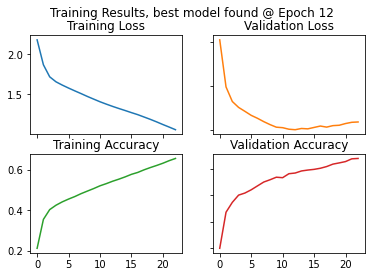

In [12]:
plot_results(train_bm1)

### Checking Accuracy of Best Model

In [13]:
# Loading new best model found:
base_model = Net.load_model("model/base_model")
base_model.test_network(train_set, "train data")
base_model.test_network(valid_set, "valid data")
base_model.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 56.18%
Total Count:  40000
Total Match:  22473
-------------------------------------------
Test Accuracy of	0: 68.21% (2748/4029)
Test Accuracy of	1: 30.04% (1208/4021)
Test Accuracy of	2: 48.23% (1921/3983)
Test Accuracy of	3: 21.83% (863/3954)
Test Accuracy of	4: 59.27% (2375/4007)
Test Accuracy of	5: 63.13% (2544/4030)
Test Accuracy of	6: 71.23% (2885/4050)
Test Accuracy of	7: 71.67% (2851/3978)
Test Accuracy of	8: 65.34% (2603/3984)
Test Accuracy of	9: 62.44% (2475/3964)
-------------------------------------------
Accuracy on valid data: 44.22%
Total Count:  10000
Total Match:  4422
-------------------------------------------
Test Accuracy of	0: 52.94% (514/971)
Test Accuracy of	1: 20.74% (203/979)
Test Accuracy of	2: 32.45% (330/1017)
Test Accuracy of	3: 16.83% (176/1046)
Test Accuracy of	4: 45.42% (451/993)
Test Accuracy of	5: 52.68% (511/970)
Test Accuracy of	6: 55.79% (530/950)
Test Accuracy of	7: 60.67% (620/1

## Model Variation 2

In [14]:
# train model till convergence
train_bm2 = base_model2.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:02<04:52,  2.95s/it]

Epoch: 0	Interval Time: 2.9 sec(s)	Training Loss: 2.221257		Training Accuracy: 0.184950
						Validation Loss:2.084858	Validation Accuracy: 0.284800


 11%|███████████████▍                                                                                                                            | 11/100 [00:31<04:19,  2.91s/it]

Epoch: 10	Interval Time: 28.3 sec(s)	Training Loss: 1.346661		Training Accuracy: 0.537025
						Validation Loss:1.703570	Validation Accuracy: 0.418800


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:00<03:48,  2.89s/it]

Epoch: 20	Interval Time: 29.1 sec(s)	Training Loss: 0.970844		Training Accuracy: 0.666900
						Validation Loss:1.723570	Validation Accuracy: 0.475000


 24%|█████████████████████████████████▌                                                                                                          | 24/100 [01:12<03:49,  3.02s/it]



No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 24.
Total training time: 1 min 12.5 s

                Best model found @ Epoch 13
                --------------------------------------------
                Training Loss: 1.246344
                Validation Loss: 1.639616
                --------------------------------------------
                Training Accuracy: 0.571225
                Validation Accuracy: 0.452800


Best model 'base_model2' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

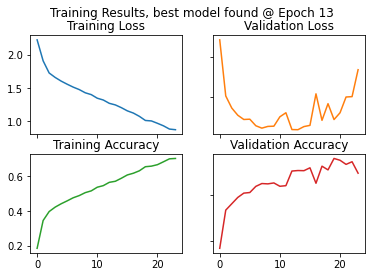

In [15]:
plot_results(train_bm2)

### Checking Accuracy of Best Model

In [16]:
# Loading new best model found:
base_model2 = Net.load_model("model/base_model2")
base_model2.test_network(train_set, "train data")
base_model2.test_network(valid_set, "valid data")
base_model2.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 61.72%
Total Count:  40000
Total Match:  24689
-------------------------------------------
Test Accuracy of	0: 73.64% (2967/4029)
Test Accuracy of	1: 30.42% (1223/4021)
Test Accuracy of	2: 53.63% (2136/3983)
Test Accuracy of	3: 35.91% (1420/3954)
Test Accuracy of	4: 46.62% (1868/4007)
Test Accuracy of	5: 67.84% (2734/4030)
Test Accuracy of	6: 81.11% (3285/4050)
Test Accuracy of	7: 72.05% (2866/3978)
Test Accuracy of	8: 77.36% (3082/3984)
Test Accuracy of	9: 78.41% (3108/3964)
-------------------------------------------
Accuracy on valid data: 45.28%
Total Count:  10000
Total Match:  4528
-------------------------------------------
Test Accuracy of	0: 52.21% (507/971)
Test Accuracy of	1: 18.49% (181/979)
Test Accuracy of	2: 33.53% (341/1017)
Test Accuracy of	3: 27.44% (287/1046)
Test Accuracy of	4: 29.71% (295/993)
Test Accuracy of	5: 51.65% (501/970)
Test Accuracy of	6: 63.68% (605/950)
Test Accuracy of	7: 58.61% (599/

## Model Variation 3

In [17]:
# train model till convergence
train_bm3 = base_model3.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:03<04:59,  3.03s/it]

Epoch: 0	Interval Time: 3.0 sec(s)	Training Loss: 2.294370		Training Accuracy: 0.101300
						Validation Loss:2.276566	Validation Accuracy: 0.096500


 11%|███████████████▍                                                                                                                            | 11/100 [00:32<04:22,  2.95s/it]

Epoch: 10	Interval Time: 29.6 sec(s)	Training Loss: 1.575543		Training Accuracy: 0.448475
						Validation Loss:1.723122	Validation Accuracy: 0.404600


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:02<03:53,  2.96s/it]

Epoch: 20	Interval Time: 30.1 sec(s)	Training Loss: 1.257484		Training Accuracy: 0.574975
						Validation Loss:1.744218	Validation Accuracy: 0.447100


 25%|███████████████████████████████████                                                                                                         | 25/100 [01:18<03:55,  3.14s/it]



Minimum percent change (1e-25%) in training loss not exceeded.

Convergence criteria achieved.
Training completed @ Epoch 25.
Total training time: 1 min 18.4 s

                Best model found @ Epoch 16
                --------------------------------------------
                Training Loss: 1.374423
                Validation Loss: 1.714888
                --------------------------------------------
                Training Accuracy: 0.530150
                Validation Accuracy: 0.430400


Best model 'base_model3' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

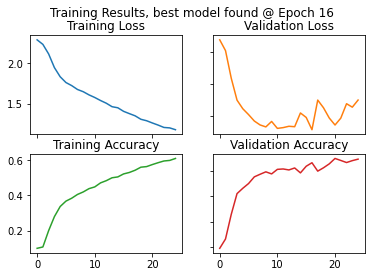

In [18]:
plot_results(train_bm3)

### Checking Accuracy of Best Model

In [19]:
# Loading new best model found:
base_model3 = Net.load_model("model/base_model3")
base_model3.test_network(train_set, "train data")
base_model3.test_network(valid_set, "valid data")
base_model3.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 58.13%
Total Count:  40000
Total Match:  23253
-------------------------------------------
Test Accuracy of	0: 60.61% (2442/4029)
Test Accuracy of	1: 23.20% (933/4021)
Test Accuracy of	2: 49.21% (1960/3983)
Test Accuracy of	3: 48.89% (1933/3954)
Test Accuracy of	4: 52.93% (2121/4007)
Test Accuracy of	5: 42.78% (1724/4030)
Test Accuracy of	6: 73.73% (2986/4050)
Test Accuracy of	7: 82.05% (3264/3978)
Test Accuracy of	8: 70.08% (2792/3984)
Test Accuracy of	9: 78.15% (3098/3964)
-------------------------------------------
Accuracy on valid data: 43.04%
Total Count:  10000
Total Match:  4304
-------------------------------------------
Test Accuracy of	0: 44.90% (436/971)
Test Accuracy of	1: 14.91% (146/979)
Test Accuracy of	2: 32.55% (331/1017)
Test Accuracy of	3: 36.14% (378/1046)
Test Accuracy of	4: 37.97% (377/993)
Test Accuracy of	5: 28.97% (281/970)
Test Accuracy of	6: 53.37% (507/950)
Test Accuracy of	7: 69.08% (706/1

# ITERATION 1: DECISION
## Selecting Model Variation 2 based on Accuracy Result on Test Set.

# ITERATION 2: Adjusting Learning Rate

## Model Variation 1: learning_rate = 0.01

In [20]:
# Initializing model hyper-parameters
lr01 = Net(
    optimizer = SGD(
        learning_rate= 0.01,  
        weight_decay = 0,
        momentum = 0,
        lr_decay = "default"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
lr01.add(Linear(128, 1024))  
lr01.add(ReLU())
lr01.add(Linear(1024, 512))                                  
lr01.add(ReLU())
lr01.add(Linear(512, 64)) 
lr01.add(ReLU())
lr01.add(Linear(64, 10))

lr01.set_name("lr01")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 2: learning_rate = 0.05

In [21]:
# Initializing model hyper-parameters
lr05 = Net(
    optimizer = SGD(
        learning_rate= 0.05,  
        weight_decay = 0,
        momentum = 0,
        lr_decay = "default"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
lr05.add(Linear(128, 1024))  
lr05.add(ReLU())
lr05.add(Linear(1024, 512))                                  
lr05.add(ReLU())
lr05.add(Linear(512, 64)) 
lr05.add(ReLU())
lr05.add(Linear(64, 10))

lr05.set_name("lr05")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 3: learning_rate = 0.1

In [22]:
# Initializing model hyper-parameters
lr1 = Net(
    optimizer = SGD(
        learning_rate= 0.1,  
        weight_decay = 0,
        momentum = 0,
        lr_decay = "default"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
lr1.add(Linear(128, 1024))  
lr1.add(ReLU())
lr1.add(Linear(1024, 512))                                  
lr1.add(ReLU())
lr1.add(Linear(512, 64)) 
lr1.add(ReLU())
lr1.add(Linear(64, 10))

lr1.set_name("lr1")  # creates name for model for loading saved model from training (with min val loss)

# ITERATION 2: TRAINING 
## Model Variation 1: learning_rate = 0.01

In [23]:
# train model till convergence
lr01s = lr01.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:02<04:49,  2.93s/it]

Epoch: 0	Interval Time: 2.9 sec(s)	Training Loss: 2.325052		Training Accuracy: 0.115700
						Validation Loss:2.292209	Validation Accuracy: 0.130500


 11%|███████████████▍                                                                                                                            | 11/100 [00:33<04:33,  3.07s/it]

Epoch: 10	Interval Time: 30.1 sec(s)	Training Loss: 1.842304		Training Accuracy: 0.372875
						Validation Loss:1.852519	Validation Accuracy: 0.361200


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:01<03:44,  2.84s/it]

Epoch: 20	Interval Time: 28.8 sec(s)	Training Loss: 1.652858		Training Accuracy: 0.424500
						Validation Loss:1.724136	Validation Accuracy: 0.392900


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [01:30<03:22,  2.93s/it]

Epoch: 30	Interval Time: 28.4 sec(s)	Training Loss: 1.572019		Training Accuracy: 0.456250
						Validation Loss:1.686197	Validation Accuracy: 0.404900


 41%|█████████████████████████████████████████████████████████▍                                                                                  | 41/100 [02:00<02:49,  2.88s/it]

Epoch: 40	Interval Time: 30.6 sec(s)	Training Loss: 1.492739		Training Accuracy: 0.485650
						Validation Loss:1.653451	Validation Accuracy: 0.421500


 51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 51/100 [02:29<02:24,  2.95s/it]

Epoch: 50	Interval Time: 29.1 sec(s)	Training Loss: 1.416478		Training Accuracy: 0.515125
						Validation Loss:1.632144	Validation Accuracy: 0.433700


 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                      | 61/100 [02:58<01:48,  2.78s/it]

Epoch: 60	Interval Time: 28.8 sec(s)	Training Loss: 1.345332		Training Accuracy: 0.543125
						Validation Loss:1.623964	Validation Accuracy: 0.441100


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 71/100 [03:26<01:19,  2.76s/it]

Epoch: 70	Interval Time: 27.6 sec(s)	Training Loss: 1.271373		Training Accuracy: 0.570400
						Validation Loss:1.621131	Validation Accuracy: 0.450300


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 81/100 [03:54<00:52,  2.76s/it]

Epoch: 80	Interval Time: 27.7 sec(s)	Training Loss: 1.189869		Training Accuracy: 0.600450
						Validation Loss:1.621034	Validation Accuracy: 0.457300


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 88/100 [04:17<00:35,  2.93s/it]



No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 88.
Total training time: 4 min 17.6 s

                Best model found @ Epoch 77
                --------------------------------------------
                Training Loss: 1.215051
                Validation Loss: 1.620170
                --------------------------------------------
                Training Accuracy: 0.592250
                Validation Accuracy: 0.454900


Best model 'lr01' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

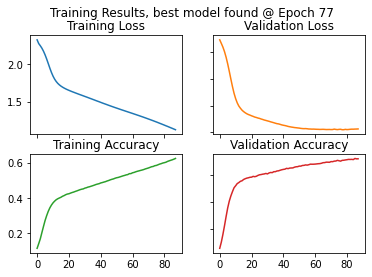

In [24]:
plot_results(lr01s)

### Checking Accuracy Results of Best Model

In [25]:
# Loading new best model found:
lr01 = Net.load_model("model/lr01")
lr01.test_network(train_set, "train data")
lr01.test_network(valid_set, "valid data")
lr01.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 59.59%
Total Count:  40000
Total Match:  23836
-------------------------------------------
Test Accuracy of	0: 68.53% (2761/4029)
Test Accuracy of	1: 34.54% (1389/4021)
Test Accuracy of	2: 45.69% (1820/3983)
Test Accuracy of	3: 30.15% (1192/3954)
Test Accuracy of	4: 57.62% (2309/4007)
Test Accuracy of	5: 67.05% (2702/4030)
Test Accuracy of	6: 72.99% (2956/4050)
Test Accuracy of	7: 78.86% (3137/3978)
Test Accuracy of	8: 74.67% (2975/3984)
Test Accuracy of	9: 65.46% (2595/3964)
-------------------------------------------
Accuracy on valid data: 45.49%
Total Count:  10000
Total Match:  4549
-------------------------------------------
Test Accuracy of	0: 53.04% (515/971)
Test Accuracy of	1: 21.45% (210/979)
Test Accuracy of	2: 29.99% (305/1017)
Test Accuracy of	3: 23.14% (242/1046)
Test Accuracy of	4: 39.88% (396/993)
Test Accuracy of	5: 53.51% (519/970)
Test Accuracy of	6: 57.26% (544/950)
Test Accuracy of	7: 68.88% (704/

## Model Variation 2: learning_rate = 0.05

In [26]:
# train model till convergence
lr05s = lr05.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:02<04:44,  2.87s/it]

Epoch: 0	Interval Time: 2.9 sec(s)	Training Loss: 2.251441		Training Accuracy: 0.158025
						Validation Loss:2.172469	Validation Accuracy: 0.230700


 11%|███████████████▍                                                                                                                            | 11/100 [00:32<04:18,  2.91s/it]

Epoch: 10	Interval Time: 29.2 sec(s)	Training Loss: 1.447038		Training Accuracy: 0.499875
						Validation Loss:1.631243	Validation Accuracy: 0.435300


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:01<04:00,  3.05s/it]

Epoch: 20	Interval Time: 29.5 sec(s)	Training Loss: 1.140745		Training Accuracy: 0.612600
						Validation Loss:1.639149	Validation Accuracy: 0.462600


 26%|████████████████████████████████████▍                                                                                                       | 26/100 [01:22<03:54,  3.17s/it]



No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 26.
Total training time: 1 min 22.5 s

                Best model found @ Epoch 15
                --------------------------------------------
                Training Loss: 1.281205
                Validation Loss: 1.601635
                --------------------------------------------
                Training Accuracy: 0.561350
                Validation Accuracy: 0.449900


Best model 'lr05' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves 

<Figure size 720x504 with 0 Axes>

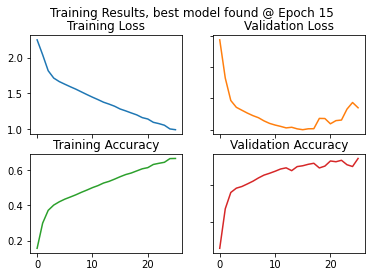

In [27]:
plot_results(lr05s)

### Checking Accuracy Results of Best Model

In [28]:
# Loading new best model found:
lr05 = Net.load_model("model/lr05")
lr05.test_network(train_set, "train data")
lr05.test_network(valid_set, "valid data")
lr05.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 58.53%
Total Count:  40000
Total Match:  23410
-------------------------------------------
Test Accuracy of	0: 70.12% (2825/4029)
Test Accuracy of	1: 37.23% (1497/4021)
Test Accuracy of	2: 39.17% (1560/3983)
Test Accuracy of	3: 32.65% (1291/3954)
Test Accuracy of	4: 55.38% (2219/4007)
Test Accuracy of	5: 61.07% (2461/4030)
Test Accuracy of	6: 77.48% (3138/4050)
Test Accuracy of	7: 81.25% (3232/3978)
Test Accuracy of	8: 72.24% (2878/3984)
Test Accuracy of	9: 58.25% (2309/3964)
-------------------------------------------
Accuracy on valid data: 44.99%
Total Count:  10000
Total Match:  4499
-------------------------------------------
Test Accuracy of	0: 52.42% (509/971)
Test Accuracy of	1: 26.25% (257/979)
Test Accuracy of	2: 24.19% (246/1017)
Test Accuracy of	3: 24.19% (253/1046)
Test Accuracy of	4: 43.50% (432/993)
Test Accuracy of	5: 48.04% (466/970)
Test Accuracy of	6: 60.21% (572/950)
Test Accuracy of	7: 70.06% (716/

## Model Variation 3: learning_rate = 0.1

In [29]:
# train model till convergence
lr1s = lr1.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:02<04:50,  2.93s/it]

Epoch: 0	Interval Time: 2.9 sec(s)	Training Loss: 2.144999		Training Accuracy: 0.223525
						Validation Loss:1.931097	Validation Accuracy: 0.324800


 11%|███████████████▍                                                                                                                            | 11/100 [00:31<04:17,  2.89s/it]

Epoch: 10	Interval Time: 29.0 sec(s)	Training Loss: 1.260909		Training Accuracy: 0.569325
						Validation Loss:1.695751	Validation Accuracy: 0.439600


 20%|████████████████████████████                                                                                                                | 20/100 [01:00<04:03,  3.05s/it]

Epoch: 20	Interval Time: 29.0 sec(s)	Training Loss: 0.986651		Training Accuracy: 0.674000
						Validation Loss:2.134790	Validation Accuracy: 0.442200


No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 20.
Total training time: 1 min 0.9 s

                Best model found @ Epoch 9
                --------------------------------------------
                Training Loss: 1.289398
                Validation Loss: 1.641991
                --------------------------------------------
                Training Accuracy: 0.560275
                Validation Accuracy: 0.442800


Best model 'lr1' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves 

<Figure size 720x504 with 0 Axes>

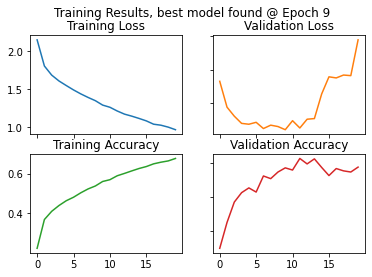

In [30]:
plot_results(lr1s)

### Checking Accuracy Results of Best Model

In [31]:
# Loading new best model found:
lr1 = Net.load_model("model/lr1")
lr1.test_network(train_set, "train data")
lr1.test_network(valid_set, "valid data")
lr1.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 59.82%
Total Count:  40000
Total Match:  23927
-------------------------------------------
Test Accuracy of	0: 70.61% (2845/4029)
Test Accuracy of	1: 50.48% (2030/4021)
Test Accuracy of	2: 49.13% (1957/3983)
Test Accuracy of	3: 29.21% (1155/3954)
Test Accuracy of	4: 54.40% (2180/4007)
Test Accuracy of	5: 58.88% (2373/4030)
Test Accuracy of	6: 57.19% (2316/4050)
Test Accuracy of	7: 79.26% (3153/3978)
Test Accuracy of	8: 75.45% (3006/3984)
Test Accuracy of	9: 73.46% (2912/3964)
-------------------------------------------
Accuracy on valid data: 44.28%
Total Count:  10000
Total Match:  4428
-------------------------------------------
Test Accuracy of	0: 52.63% (511/971)
Test Accuracy of	1: 34.53% (338/979)
Test Accuracy of	2: 28.61% (291/1017)
Test Accuracy of	3: 20.27% (212/1046)
Test Accuracy of	4: 38.57% (383/993)
Test Accuracy of	5: 44.02% (427/970)
Test Accuracy of	6: 40.53% (385/950)
Test Accuracy of	7: 66.44% (679/

# ITERATION 2: DECISION
## Selecting learning_rate = 0.05 based on Accuracy Result on Test Set.

# ITERATION 3: Adding Momentum

## Model Variation 1: momentum = 0.9

In [32]:
# Initializing model hyper-parameters
m9 = Net(
    optimizer = SGD(
        learning_rate= 0.05,  
        weight_decay = 0,
        momentum = 0.9,
        lr_decay = "default"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
m9.add(Linear(128, 1024))  
m9.add(ReLU())
m9.add(Linear(1024, 512))                                  
m9.add(ReLU())
m9.add(Linear(512, 64)) 
m9.add(ReLU())
m9.add(Linear(64, 10))

m9.set_name("m9")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 2: momentum = 0.95

In [33]:
# Initializing model hyper-parameters
m95 = Net(
    optimizer = SGD(
        learning_rate= 0.05,  
        weight_decay = 0,
        momentum = 0.95,
        lr_decay = "default"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
m95.add(Linear(128, 1024))  
m95.add(ReLU())
m95.add(Linear(1024, 512))                                  
m95.add(ReLU())
m95.add(Linear(512, 64)) 
m95.add(ReLU())
m95.add(Linear(64, 10))

m95.set_name("m95")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 3: momentum = 0.999

In [34]:
# Initializing model hyper-parameters
m99 = Net(
    optimizer = SGD(
        learning_rate= 0.05,  
        weight_decay = 0,
        momentum = 0.999,
        lr_decay = "default"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
m99.add(Linear(128, 1024))  
m99.add(ReLU())
m99.add(Linear(1024, 512))                                  
m99.add(ReLU())
m99.add(Linear(512, 64)) 
m99.add(ReLU())
m99.add(Linear(64, 10))

m99.set_name("m99")  # creates name for model for loading saved model from training (with min val loss)

# ITERATION 3: TRAINING
## Model Variation 1: momentum = 0.9

In [35]:
# train model till convergence
m9s = m9.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:02<04:51,  2.94s/it]

Epoch: 0	Interval Time: 2.9 sec(s)	Training Loss: 2.245411		Training Accuracy: 0.168225
						Validation Loss:2.147472	Validation Accuracy: 0.242700


 11%|███████████████▍                                                                                                                            | 11/100 [00:31<04:18,  2.90s/it]

Epoch: 10	Interval Time: 29.1 sec(s)	Training Loss: 1.438358		Training Accuracy: 0.503800
						Validation Loss:1.639871	Validation Accuracy: 0.428600


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:00<03:45,  2.85s/it]

Epoch: 20	Interval Time: 28.8 sec(s)	Training Loss: 1.112076		Training Accuracy: 0.622600
						Validation Loss:1.672496	Validation Accuracy: 0.458200


 26%|████████████████████████████████████▍                                                                                                       | 26/100 [01:17<03:41,  2.99s/it]



No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 26.
Total training time: 1 min 17.8 s

                Best model found @ Epoch 15
                --------------------------------------------
                Training Loss: 1.274029
                Validation Loss: 1.622253
                --------------------------------------------
                Training Accuracy: 0.569150
                Validation Accuracy: 0.446200


Best model 'm9' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

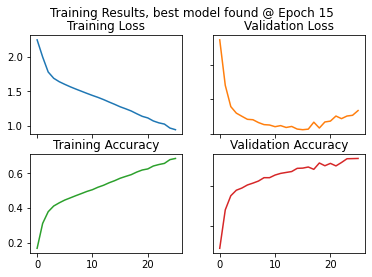

In [36]:
plot_results(m9s)

### Checking Accuracy of Best Model

In [37]:
# Loading new best model found:
m9 = Net.load_model("model/m9")
m9.test_network(train_set, "train data")
m9.test_network(valid_set, "valid data")
m9.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 59.13%
Total Count:  40000
Total Match:  23650
-------------------------------------------
Test Accuracy of	0: 75.50% (3042/4029)
Test Accuracy of	1: 42.38% (1704/4021)
Test Accuracy of	2: 42.36% (1687/3983)
Test Accuracy of	3: 30.96% (1224/3954)
Test Accuracy of	4: 57.50% (2304/4007)
Test Accuracy of	5: 63.35% (2553/4030)
Test Accuracy of	6: 71.09% (2879/4050)
Test Accuracy of	7: 77.25% (3073/3978)
Test Accuracy of	8: 61.82% (2463/3984)
Test Accuracy of	9: 68.64% (2721/3964)
-------------------------------------------
Accuracy on valid data: 44.62%
Total Count:  10000
Total Match:  4462
-------------------------------------------
Test Accuracy of	0: 61.28% (595/971)
Test Accuracy of	1: 26.66% (261/979)
Test Accuracy of	2: 27.14% (276/1017)
Test Accuracy of	3: 22.75% (238/1046)
Test Accuracy of	4: 40.79% (405/993)
Test Accuracy of	5: 50.31% (488/970)
Test Accuracy of	6: 53.58% (509/950)
Test Accuracy of	7: 66.05% (675/

## Model Variation 2: momentum = 0.95

In [38]:
# train model till convergence
m95s = m95.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:02<04:49,  2.93s/it]

Epoch: 0	Interval Time: 2.9 sec(s)	Training Loss: 2.248136		Training Accuracy: 0.166775
						Validation Loss:2.165693	Validation Accuracy: 0.240400


 11%|███████████████▍                                                                                                                            | 11/100 [00:31<04:16,  2.88s/it]

Epoch: 10	Interval Time: 28.8 sec(s)	Training Loss: 1.457530		Training Accuracy: 0.496025
						Validation Loss:1.642815	Validation Accuracy: 0.427400


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:00<03:47,  2.88s/it]

Epoch: 20	Interval Time: 28.8 sec(s)	Training Loss: 1.143395		Training Accuracy: 0.610975
						Validation Loss:1.666837	Validation Accuracy: 0.456800


 27%|█████████████████████████████████████▊                                                                                                      | 27/100 [01:20<03:37,  2.98s/it]



No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 27.
Total training time: 1 min 20.6 s

                Best model found @ Epoch 16
                --------------------------------------------
                Training Loss: 1.270377
                Validation Loss: 1.625719
                --------------------------------------------
                Training Accuracy: 0.566700
                Validation Accuracy: 0.452300


Best model 'm95' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

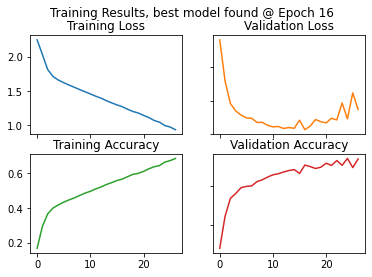

In [39]:
plot_results(m95s)

### Checking Accuracy of Best Model

In [40]:
# Loading new best model found:
m95 = Net.load_model("model/m95")
m95.test_network(train_set, "train data")
m95.test_network(valid_set, "valid data")
m95.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 60.04%
Total Count:  40000
Total Match:  24014
-------------------------------------------
Test Accuracy of	0: 73.52% (2962/4029)
Test Accuracy of	1: 38.37% (1543/4021)
Test Accuracy of	2: 53.98% (2150/3983)
Test Accuracy of	3: 34.40% (1360/3954)
Test Accuracy of	4: 60.52% (2425/4007)
Test Accuracy of	5: 62.33% (2512/4030)
Test Accuracy of	6: 70.69% (2863/4050)
Test Accuracy of	7: 77.50% (3083/3978)
Test Accuracy of	8: 66.92% (2666/3984)
Test Accuracy of	9: 61.81% (2450/3964)
-------------------------------------------
Accuracy on valid data: 45.23%
Total Count:  10000
Total Match:  4523
-------------------------------------------
Test Accuracy of	0: 58.19% (565/971)
Test Accuracy of	1: 24.11% (236/979)
Test Accuracy of	2: 34.02% (346/1017)
Test Accuracy of	3: 23.61% (247/1046)
Test Accuracy of	4: 44.71% (444/993)
Test Accuracy of	5: 48.45% (470/970)
Test Accuracy of	6: 54.32% (516/950)
Test Accuracy of	7: 65.07% (665/

## Model Variation 3: momentum = 0.999

In [41]:
# train model till convergence
m99s = m99.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:02<04:53,  2.97s/it]

Epoch: 0	Interval Time: 3.0 sec(s)	Training Loss: 2.242613		Training Accuracy: 0.168700
						Validation Loss:2.149202	Validation Accuracy: 0.238000


 11%|███████████████▍                                                                                                                            | 11/100 [00:32<04:21,  2.94s/it]

Epoch: 10	Interval Time: 29.5 sec(s)	Training Loss: 1.457911		Training Accuracy: 0.498050
						Validation Loss:1.658141	Validation Accuracy: 0.421900


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:01<03:44,  2.84s/it]

Epoch: 20	Interval Time: 28.8 sec(s)	Training Loss: 1.116891		Training Accuracy: 0.622725
						Validation Loss:1.659858	Validation Accuracy: 0.466900


 27%|█████████████████████████████████████▊                                                                                                      | 27/100 [01:21<03:40,  3.02s/it]



No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 27.
Total training time: 1 min 21.6 s

                Best model found @ Epoch 16
                --------------------------------------------
                Training Loss: 1.243127
                Validation Loss: 1.618077
                --------------------------------------------
                Training Accuracy: 0.578100
                Validation Accuracy: 0.459200


Best model 'm99' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

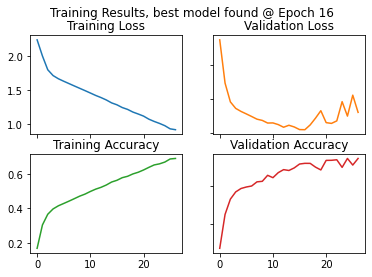

In [42]:
plot_results(m99s)

### Checking Accuracy of Best Model

In [43]:
# Loading new best model found:
m99 = Net.load_model("model/m99")
m99.test_network(train_set, "train data")
m99.test_network(valid_set, "valid data")
m99.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 60.74%
Total Count:  40000
Total Match:  24296
-------------------------------------------
Test Accuracy of	0: 78.48% (3162/4029)
Test Accuracy of	1: 34.62% (1392/4021)
Test Accuracy of	2: 49.54% (1973/3983)
Test Accuracy of	3: 33.51% (1325/3954)
Test Accuracy of	4: 49.51% (1984/4007)
Test Accuracy of	5: 68.64% (2766/4030)
Test Accuracy of	6: 74.44% (3015/4050)
Test Accuracy of	7: 78.33% (3116/3978)
Test Accuracy of	8: 69.03% (2750/3984)
Test Accuracy of	9: 70.96% (2813/3964)
-------------------------------------------
Accuracy on valid data: 45.92%
Total Count:  10000
Total Match:  4592
-------------------------------------------
Test Accuracy of	0: 58.60% (569/971)
Test Accuracy of	1: 22.17% (217/979)
Test Accuracy of	2: 30.97% (315/1017)
Test Accuracy of	3: 26.00% (272/1046)
Test Accuracy of	4: 34.24% (340/993)
Test Accuracy of	5: 55.05% (534/970)
Test Accuracy of	6: 57.16% (543/950)
Test Accuracy of	7: 66.63% (681/

# ITERATION 3: DECISION
## Applying momentum = 0.999 based on Accuracy Result on Test Set.

# ITERATION 4: Weight Decay

## Model Variation 1: weight_decay = 0.001

In [44]:
# Initializing model hyper-parameters
wd001 = Net(
    optimizer = SGD(
        learning_rate= 0.05,  
        weight_decay = 0.001,  # i.e. layer.W += lr * (-layer.dW - self.weight_decay * layer.W)
        momentum = 0.999,
        lr_decay = "default"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
wd001.add(Linear(128, 1024))  
wd001.add(ReLU())
wd001.add(Linear(1024, 512))                                  
wd001.add(ReLU())
wd001.add(Linear(512, 64)) 
wd001.add(ReLU())
wd001.add(Linear(64, 10))

wd001.set_name("wd001")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 2: weight_decay = 0.005

In [45]:
# Initializing model hyper-parameters
wd005 = Net(
    optimizer = SGD(
        learning_rate= 0.05,  
        weight_decay = 0.005,  # i.e. layer.W += lr * (-layer.dW - self.weight_decay * layer.W)
        momentum = 0.999,
        lr_decay = "default"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
wd005.add(Linear(128, 1024))  
wd005.add(ReLU())
wd005.add(Linear(1024, 512))                                  
wd005.add(ReLU())
wd005.add(Linear(512, 64)) 
wd005.add(ReLU())
wd005.add(Linear(64, 10))

wd005.set_name("wd005")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 3: weight_decay = 0.003

In [46]:
# Initializing model hyper-parameters
wd003 = Net(
    optimizer = SGD(
        learning_rate= 0.05,  
        weight_decay = 0.003,  # i.e. layer.W += lr * (-layer.dW - self.weight_decay * layer.W)
        momentum = 0.999,
        lr_decay = "default"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
wd003.add(Linear(128, 1024))  
wd003.add(ReLU())
wd003.add(Linear(1024, 512))                                  
wd003.add(ReLU())
wd003.add(Linear(512, 64)) 
wd003.add(ReLU())
wd003.add(Linear(64, 10))

wd003.set_name("wd003")  # creates name for model for loading saved model from training (with min val loss)

# ITERATION 4: TRAINING
## Model Variation 1: weight_decay = 0.001

In [47]:
# train model till convergence
wd001s = wd001.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:02<04:39,  2.83s/it]

Epoch: 0	Interval Time: 2.8 sec(s)	Training Loss: 2.265037		Training Accuracy: 0.158750
						Validation Loss:2.204942	Validation Accuracy: 0.213800


 11%|███████████████▍                                                                                                                            | 11/100 [00:32<04:22,  2.95s/it]

Epoch: 10	Interval Time: 29.3 sec(s)	Training Loss: 1.475020		Training Accuracy: 0.495400
						Validation Loss:1.649382	Validation Accuracy: 0.427800


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:01<03:48,  2.89s/it]

Epoch: 20	Interval Time: 29.2 sec(s)	Training Loss: 1.163645		Training Accuracy: 0.610250
						Validation Loss:1.663633	Validation Accuracy: 0.451300


 25%|███████████████████████████████████                                                                                                         | 25/100 [01:15<03:47,  3.04s/it]



No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 25.
Total training time: 1 min 15.9 s

                Best model found @ Epoch 14
                --------------------------------------------
                Training Loss: 1.350683
                Validation Loss: 1.626828
                --------------------------------------------
                Training Accuracy: 0.541450
                Validation Accuracy: 0.442600


Best model 'wd001' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

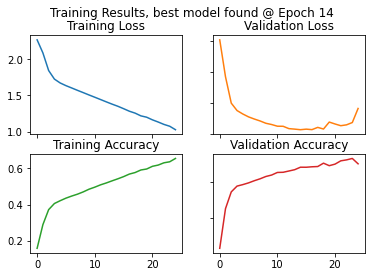

In [48]:
plot_results(wd001s)

### Checking Accuracy of Best Model

In [49]:
# Loading new best model found:
wd001 = Net.load_model("model/wd001")
wd001.test_network(train_set, "train data")
wd001.test_network(valid_set, "valid data")
wd001.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 56.50%
Total Count:  40000
Total Match:  22599
-------------------------------------------
Test Accuracy of	0: 67.06% (2702/4029)
Test Accuracy of	1: 32.13% (1292/4021)
Test Accuracy of	2: 48.33% (1925/3983)
Test Accuracy of	3: 19.60% (775/3954)
Test Accuracy of	4: 57.37% (2299/4007)
Test Accuracy of	5: 62.23% (2508/4030)
Test Accuracy of	6: 68.10% (2758/4050)
Test Accuracy of	7: 75.97% (3022/3978)
Test Accuracy of	8: 66.77% (2660/3984)
Test Accuracy of	9: 67.05% (2658/3964)
-------------------------------------------
Accuracy on valid data: 44.26%
Total Count:  10000
Total Match:  4426
-------------------------------------------
Test Accuracy of	0: 50.88% (494/971)
Test Accuracy of	1: 22.27% (218/979)
Test Accuracy of	2: 30.58% (311/1017)
Test Accuracy of	3: 14.82% (155/1046)
Test Accuracy of	4: 44.91% (446/993)
Test Accuracy of	5: 51.44% (499/970)
Test Accuracy of	6: 55.26% (525/950)
Test Accuracy of	7: 64.77% (662/1

## Model Variation 2: weight_decay = 0.005

In [50]:
# train model till convergence
wd005s = wd005.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:02<04:51,  2.94s/it]

Epoch: 0	Interval Time: 2.9 sec(s)	Training Loss: 2.252131		Training Accuracy: 0.154825
						Validation Loss:2.172299	Validation Accuracy: 0.215900


 11%|███████████████▍                                                                                                                            | 11/100 [00:35<04:39,  3.15s/it]

Epoch: 10	Interval Time: 32.8 sec(s)	Training Loss: 1.562373		Training Accuracy: 0.460450
						Validation Loss:1.687489	Validation Accuracy: 0.408200


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:05<03:52,  2.94s/it]

Epoch: 20	Interval Time: 29.9 sec(s)	Training Loss: 1.361610		Training Accuracy: 0.537350
						Validation Loss:1.652447	Validation Accuracy: 0.431000


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [01:35<03:23,  2.95s/it]

Epoch: 30	Interval Time: 29.5 sec(s)	Training Loss: 1.088056		Training Accuracy: 0.636600
						Validation Loss:1.629404	Validation Accuracy: 0.469400


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [01:37<03:38,  3.16s/it]



Minimum percent change (1e-25%) in training loss not exceeded.

Convergence criteria achieved.
Training completed @ Epoch 31.
Total training time: 1 min 38.0 s

                Best model found @ Epoch 27
                --------------------------------------------
                Training Loss: 1.145424
                Validation Loss: 1.585988
                --------------------------------------------
                Training Accuracy: 0.615800
                Validation Accuracy: 0.470300


Best model 'wd005' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

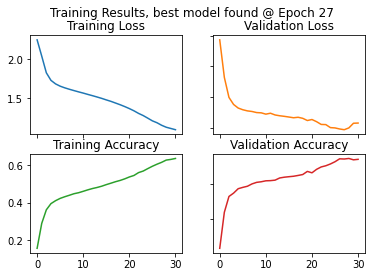

In [51]:
plot_results(wd005s)

### Checking Accuracy of Best Model

In [52]:
# Loading new best model found:
wd005 = Net.load_model("model/wd005")
wd005.test_network(train_set, "train data")
wd005.test_network(valid_set, "valid data")
wd005.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 64.30%
Total Count:  40000
Total Match:  25719
-------------------------------------------
Test Accuracy of	0: 71.01% (2861/4029)
Test Accuracy of	1: 47.65% (1916/4021)
Test Accuracy of	2: 36.88% (1469/3983)
Test Accuracy of	3: 46.41% (1835/3954)
Test Accuracy of	4: 55.88% (2239/4007)
Test Accuracy of	5: 79.31% (3196/4030)
Test Accuracy of	6: 73.48% (2976/4050)
Test Accuracy of	7: 82.03% (3263/3978)
Test Accuracy of	8: 80.82% (3220/3984)
Test Accuracy of	9: 69.22% (2744/3964)
-------------------------------------------
Accuracy on valid data: 47.03%
Total Count:  10000
Total Match:  4703
-------------------------------------------
Test Accuracy of	0: 51.39% (499/971)
Test Accuracy of	1: 29.32% (287/979)
Test Accuracy of	2: 23.01% (234/1017)
Test Accuracy of	3: 33.08% (346/1046)
Test Accuracy of	4: 40.38% (401/993)
Test Accuracy of	5: 59.48% (577/970)
Test Accuracy of	6: 52.84% (502/950)
Test Accuracy of	7: 69.96% (715/

## Model Variation 3: weight_decay = 0.003

In [53]:
# train model till convergence
wd003s = wd003.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:02<04:56,  2.99s/it]

Epoch: 0	Interval Time: 3.0 sec(s)	Training Loss: 2.236707		Training Accuracy: 0.178000
						Validation Loss:2.143339	Validation Accuracy: 0.254200


 11%|███████████████▍                                                                                                                            | 11/100 [00:34<04:54,  3.31s/it]

Epoch: 10	Interval Time: 31.4 sec(s)	Training Loss: 1.496019		Training Accuracy: 0.487150
						Validation Loss:1.658251	Validation Accuracy: 0.424800


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:03<03:53,  2.95s/it]

Epoch: 20	Interval Time: 29.5 sec(s)	Training Loss: 1.237468		Training Accuracy: 0.582625
						Validation Loss:1.624173	Validation Accuracy: 0.459800


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [01:34<03:27,  3.01s/it]

Epoch: 30	Interval Time: 30.4 sec(s)	Training Loss: 0.941664		Training Accuracy: 0.685025
						Validation Loss:1.784946	Validation Accuracy: 0.460600


 37%|███████████████████████████████████████████████████▊                                                                                        | 37/100 [01:54<03:15,  3.10s/it]



No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 37.
Total training time: 1 min 54.7 s

                Best model found @ Epoch 26
                --------------------------------------------
                Training Loss: 1.043466
                Validation Loss: 1.612123
                --------------------------------------------
                Training Accuracy: 0.649675
                Validation Accuracy: 0.480700


Best model 'wd003' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

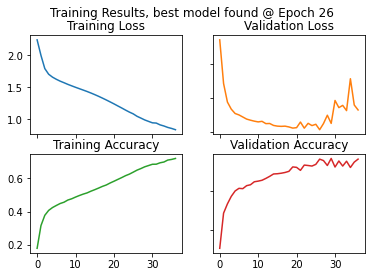

In [54]:
plot_results(wd003s)

### Checking Accuracy of Best Model

In [55]:
# Loading new best model found:
wd003 = Net.load_model("model/wd003")
wd003.test_network(train_set, "train data")
wd003.test_network(valid_set, "valid data")
wd003.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 68.57%
Total Count:  40000
Total Match:  27428
-------------------------------------------
Test Accuracy of	0: 79.85% (3217/4029)
Test Accuracy of	1: 56.68% (2279/4021)
Test Accuracy of	2: 47.15% (1878/3983)
Test Accuracy of	3: 50.10% (1981/3954)
Test Accuracy of	4: 58.57% (2347/4007)
Test Accuracy of	5: 71.51% (2882/4030)
Test Accuracy of	6: 79.01% (3200/4050)
Test Accuracy of	7: 81.55% (3244/3978)
Test Accuracy of	8: 81.33% (3240/3984)
Test Accuracy of	9: 79.72% (3160/3964)
-------------------------------------------
Accuracy on valid data: 48.07%
Total Count:  10000
Total Match:  4807
-------------------------------------------
Test Accuracy of	0: 54.89% (533/971)
Test Accuracy of	1: 32.69% (320/979)
Test Accuracy of	2: 28.52% (290/1017)
Test Accuracy of	3: 34.99% (366/1046)
Test Accuracy of	4: 40.99% (407/993)
Test Accuracy of	5: 50.82% (493/970)
Test Accuracy of	6: 55.16% (524/950)
Test Accuracy of	7: 67.51% (690/

# ITERATION 4: DECISION
## Applying weight_decay = 0.003 based on Accuracy Result on Test Set.

# ITERATION 5: Learning Rate Scheduler

## Model Variation 1: Time Decay of LR

In [56]:
# Initializing model hyper-parameters
time = Net(
    optimizer = SGD(
        learning_rate= 0.05,  
        weight_decay = 0.003,
        momentum = 0.999,
        lr_decay = "time"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
time.add(Linear(128, 1024))  
time.add(ReLU())
time.add(Linear(1024, 512))                                  
time.add(ReLU())
time.add(Linear(512, 64)) 
time.add(ReLU())
time.add(Linear(64, 10))

time.set_name("time")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 2: Exponential Decay of LR

In [57]:
# Initializing model hyper-parameters
exp = Net(
    optimizer = SGD(
        learning_rate= 0.05,  
        weight_decay = 0.003,
        momentum = 0.999,
        lr_decay = "exp"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
exp.add(Linear(128, 1024))  
exp.add(ReLU())
exp.add(Linear(1024, 512))                                  
exp.add(ReLU())
exp.add(Linear(512, 64)) 
exp.add(ReLU())
exp.add(Linear(64, 10))

exp.set_name("exp")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 3: Step Decay of LR

In [58]:
# Initializing model hyper-parameters
step = Net(
    optimizer = SGD(
        learning_rate= 0.05,  
        weight_decay = 0.003,
        momentum = 0.999, 
        lr_decay = "step"   # default step terms (10, .5) i.e. drop by half every step of 10 epochs
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
step.add(Linear(128, 1024))  
step.add(ReLU())
step.add(Linear(1024, 512))                                  
step.add(ReLU())
step.add(Linear(512, 64)) 
step.add(ReLU())
step.add(Linear(64, 10))

step.set_name("step")  # creates name for model for loading saved model from training (with min val loss)

# ITERATION 5: TRAINING

## Model Variation 1: Time Decay of LR

In [59]:
# train model till convergence
tds = time.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:03<05:35,  3.39s/it]

Epoch: 0	Interval Time: 3.4 sec(s)	Training Loss: 2.240910		Training Accuracy: 0.177400
						Validation Loss:2.154898	Validation Accuracy: 0.242500


 11%|███████████████▍                                                                                                                            | 11/100 [00:33<04:23,  2.96s/it]

Epoch: 10	Interval Time: 29.7 sec(s)	Training Loss: 1.547964		Training Accuracy: 0.469175
						Validation Loss:1.678447	Validation Accuracy: 0.413100


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:02<03:53,  2.96s/it]

Epoch: 20	Interval Time: 29.4 sec(s)	Training Loss: 1.380404		Training Accuracy: 0.532075
						Validation Loss:1.639636	Validation Accuracy: 0.436400


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [01:31<03:19,  2.88s/it]

Epoch: 30	Interval Time: 29.3 sec(s)	Training Loss: 1.202150		Training Accuracy: 0.597875
						Validation Loss:1.609521	Validation Accuracy: 0.455900


 41%|█████████████████████████████████████████████████████████▍                                                                                  | 41/100 [02:02<02:57,  3.01s/it]

Epoch: 40	Interval Time: 30.3 sec(s)	Training Loss: 1.023100		Training Accuracy: 0.666175
						Validation Loss:1.596176	Validation Accuracy: 0.476500


 48%|███████████████████████████████████████████████████████████████████▏                                                                        | 48/100 [02:25<02:37,  3.04s/it]



No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 48.
Total training time: 2 min 25.7 s

                Best model found @ Epoch 37
                --------------------------------------------
                Training Loss: 1.074545
                Validation Loss: 1.593321
                --------------------------------------------
                Training Accuracy: 0.645450
                Validation Accuracy: 0.471100


Best model 'time' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

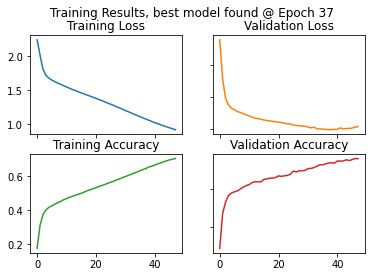

In [60]:
plot_results(tds)

### Checking Accuracy of Best Model

In [61]:
# Loading new best model found:
td = Net.load_model("model/time")
td.test_network(train_set, "train data")
td.test_network(valid_set, "valid data")
td.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 65.92%
Total Count:  40000
Total Match:  26368
-------------------------------------------
Test Accuracy of	0: 70.74% (2850/4029)
Test Accuracy of	1: 50.88% (2046/4021)
Test Accuracy of	2: 47.75% (1902/3983)
Test Accuracy of	3: 43.85% (1734/3954)
Test Accuracy of	4: 57.95% (2322/4007)
Test Accuracy of	5: 71.14% (2867/4030)
Test Accuracy of	6: 77.70% (3147/4050)
Test Accuracy of	7: 83.11% (3306/3978)
Test Accuracy of	8: 79.59% (3171/3984)
Test Accuracy of	9: 76.26% (3023/3964)
-------------------------------------------
Accuracy on valid data: 47.11%
Total Count:  10000
Total Match:  4711
-------------------------------------------
Test Accuracy of	0: 50.36% (489/971)
Test Accuracy of	1: 31.87% (312/979)
Test Accuracy of	2: 27.14% (276/1017)
Test Accuracy of	3: 30.50% (319/1046)
Test Accuracy of	4: 40.18% (399/993)
Test Accuracy of	5: 52.99% (514/970)
Test Accuracy of	6: 56.11% (533/950)
Test Accuracy of	7: 69.77% (713/

## Model Variation 2: Exponential Decay of LR

In [62]:
# train model till convergence
eds = exp.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:03<05:02,  3.06s/it]

Epoch: 0	Interval Time: 3.0 sec(s)	Training Loss: 2.240953		Training Accuracy: 0.172150
						Validation Loss:2.153708	Validation Accuracy: 0.244300


 11%|███████████████▍                                                                                                                            | 11/100 [00:32<04:22,  2.95s/it]

Epoch: 10	Interval Time: 29.9 sec(s)	Training Loss: 1.489970		Training Accuracy: 0.485725
						Validation Loss:1.641890	Validation Accuracy: 0.425000


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:02<03:50,  2.92s/it]

Epoch: 20	Interval Time: 29.4 sec(s)	Training Loss: 1.285888		Training Accuracy: 0.563325
						Validation Loss:1.611803	Validation Accuracy: 0.452500


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [01:32<03:29,  3.04s/it]

Epoch: 30	Interval Time: 30.1 sec(s)	Training Loss: 1.015076		Training Accuracy: 0.662600
						Validation Loss:1.606003	Validation Accuracy: 0.476000


 39%|██████████████████████████████████████████████████████▌                                                                                     | 39/100 [01:58<03:05,  3.04s/it]



No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 39.
Total training time: 1 min 58.7 s

                Best model found @ Epoch 28
                --------------------------------------------
                Training Loss: 1.069294
                Validation Loss: 1.588846
                --------------------------------------------
                Training Accuracy: 0.641200
                Validation Accuracy: 0.477200


Best model 'exp' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

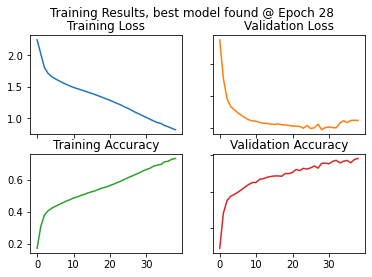

In [63]:
plot_results(eds)

### Checking Accuracy of Best Model

In [64]:
# Loading new best model found:
ed = Net.load_model("model/exp")
ed.test_network(train_set, "train data")
ed.test_network(valid_set, "valid data")
ed.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 66.86%
Total Count:  40000
Total Match:  26746
-------------------------------------------
Test Accuracy of	0: 74.06% (2984/4029)
Test Accuracy of	1: 45.83% (1843/4021)
Test Accuracy of	2: 50.77% (2022/3983)
Test Accuracy of	3: 41.45% (1639/3954)
Test Accuracy of	4: 56.80% (2276/4007)
Test Accuracy of	5: 82.26% (3315/4030)
Test Accuracy of	6: 80.57% (3263/4050)
Test Accuracy of	7: 86.27% (3432/3978)
Test Accuracy of	8: 75.58% (3011/3984)
Test Accuracy of	9: 74.70% (2961/3964)
-------------------------------------------
Accuracy on valid data: 47.72%
Total Count:  10000
Total Match:  4772
-------------------------------------------
Test Accuracy of	0: 53.76% (522/971)
Test Accuracy of	1: 24.62% (241/979)
Test Accuracy of	2: 32.65% (332/1017)
Test Accuracy of	3: 28.68% (300/1046)
Test Accuracy of	4: 37.56% (373/993)
Test Accuracy of	5: 62.89% (610/970)
Test Accuracy of	6: 56.53% (537/950)
Test Accuracy of	7: 71.82% (734/

## Model Variation 3: Step Decay of LR (Default)
##### Drop = 0.5, Step = 10

In [65]:
# train model till convergence
sds = step.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:03<05:36,  3.40s/it]

Epoch: 0	Interval Time: 3.4 sec(s)	Training Loss: 2.240226		Training Accuracy: 0.163700
						Validation Loss:2.145110	Validation Accuracy: 0.249100


 11%|███████████████▍                                                                                                                            | 11/100 [00:34<04:30,  3.04s/it]

Epoch: 10	Interval Time: 31.6 sec(s)	Training Loss: 1.517721		Training Accuracy: 0.477750
						Validation Loss:1.671138	Validation Accuracy: 0.417400


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:07<04:04,  3.10s/it]

Epoch: 20	Interval Time: 32.6 sec(s)	Training Loss: 1.406509		Training Accuracy: 0.523525
						Validation Loss:1.654155	Validation Accuracy: 0.430200


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [01:37<03:23,  2.95s/it]

Epoch: 30	Interval Time: 29.6 sec(s)	Training Loss: 1.339832		Training Accuracy: 0.549800
						Validation Loss:1.647625	Validation Accuracy: 0.436700


 41%|█████████████████████████████████████████████████████████▍                                                                                  | 41/100 [02:06<02:54,  2.96s/it]

Epoch: 40	Interval Time: 29.8 sec(s)	Training Loss: 1.301365		Training Accuracy: 0.562900
						Validation Loss:1.644041	Validation Accuracy: 0.440400


 51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 51/100 [02:36<02:30,  3.06s/it]

Epoch: 50	Interval Time: 29.9 sec(s)	Training Loss: 1.280567		Training Accuracy: 0.570350
						Validation Loss:1.641481	Validation Accuracy: 0.443700


 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                      | 61/100 [03:05<01:52,  2.90s/it]

Epoch: 60	Interval Time: 29.0 sec(s)	Training Loss: 1.269749		Training Accuracy: 0.574400
						Validation Loss:1.640655	Validation Accuracy: 0.444800


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 71/100 [03:34<01:21,  2.81s/it]

Epoch: 70	Interval Time: 28.4 sec(s)	Training Loss: 1.264260		Training Accuracy: 0.576700
						Validation Loss:1.640054	Validation Accuracy: 0.445900


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 81/100 [04:02<00:53,  2.79s/it]

Epoch: 80	Interval Time: 28.1 sec(s)	Training Loss: 1.261471		Training Accuracy: 0.578050
						Validation Loss:1.639796	Validation Accuracy: 0.447400


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 91/100 [04:30<00:25,  2.84s/it]

Epoch: 90	Interval Time: 28.3 sec(s)	Training Loss: 1.260069		Training Accuracy: 0.578200
						Validation Loss:1.639647	Validation Accuracy: 0.447900


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:57<00:00,  2.97s/it]



Maximum planned number of epoch(s) exhausted.

Training is complete @ Epoch 99.
Total training time: 4 min 57.4 s

                Best model found @ Epoch 99
                --------------------------------------------
                Training Loss: 1.259404
                Validation Loss: 1.639591
                --------------------------------------------
                Training Accuracy: 0.578500
                Validation Accuracy: 0.448100


Best model 'step' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

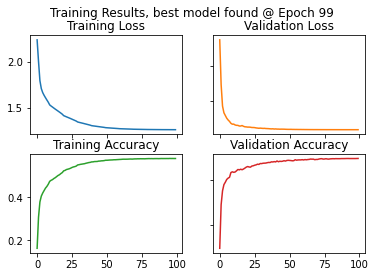

In [66]:
plot_results(sds)

### Checking Accuracy of Best Model

In [67]:
# Loading new best model found:
sd = Net.load_model("model/step")
sd.test_network(train_set, "train data")
sd.test_network(valid_set, "valid data")
sd.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 57.86%
Total Count:  40000
Total Match:  23143
-------------------------------------------
Test Accuracy of	0: 68.11% (2744/4029)
Test Accuracy of	1: 31.63% (1272/4021)
Test Accuracy of	2: 44.41% (1769/3983)
Test Accuracy of	3: 29.49% (1166/3954)
Test Accuracy of	4: 50.66% (2030/4007)
Test Accuracy of	5: 63.80% (2571/4030)
Test Accuracy of	6: 74.99% (3037/4050)
Test Accuracy of	7: 79.49% (3162/3978)
Test Accuracy of	8: 70.18% (2796/3984)
Test Accuracy of	9: 65.49% (2596/3964)
-------------------------------------------
Accuracy on valid data: 44.81%
Total Count:  10000
Total Match:  4481
-------------------------------------------
Test Accuracy of	0: 50.98% (495/971)
Test Accuracy of	1: 21.04% (206/979)
Test Accuracy of	2: 29.20% (297/1017)
Test Accuracy of	3: 22.66% (237/1046)
Test Accuracy of	4: 37.76% (375/993)
Test Accuracy of	5: 51.65% (501/970)
Test Accuracy of	6: 56.00% (532/950)
Test Accuracy of	7: 70.74% (723/

## Model Variation 3A: Step Decay of LR (Non-Default)
##### Drop = 0.90, Step = 25 (Drop by 10% every step of 25 epochs)

In [68]:
# Initializing model hyper-parameters
step1 = Net(
    optimizer = SGD(
        learning_rate= 0.05,  
        weight_decay = 0.003,
        momentum = 0.999, 
        lr_decay = "step",  
        step_terms = (25, 0.9) # every step of 25 epochs, drop LR by 10%
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
step1.add(Linear(128, 1024))  
step1.add(ReLU())
step1.add(Linear(1024, 512))                                  
step1.add(ReLU())
step1.add(Linear(512, 64)) 
step1.add(ReLU())
step1.add(Linear(64, 10))

step1.set_name("step1")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 3B: Step Decay of LR (Non-Default)
##### Drop = 0.95, Step = 25 (Drop by 5% every step of 25 epochs)

In [69]:
# Initializing model hyper-parameters
step2 = Net(
    optimizer = SGD(
        learning_rate= 0.05,  
        weight_decay = 0.003,
        momentum = 0.999, 
        lr_decay = "step",  
        step_terms = (25, 0.95) # every step of 25 epochs, drop LR by 5%
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0
)

# Adding Layers (and setting Layer hyper-parameters)
step2.add(Linear(128, 1024))  
step2.add(ReLU())
step2.add(Linear(1024, 512))                                  
step2.add(ReLU())
step2.add(Linear(512, 64)) 
step2.add(ReLU())
step2.add(Linear(64, 10))

step2.set_name("step2")  # creates name for model for loading saved model from training (with min val loss)

## ITERATION 5* (Step Decay - non-default): TRAINING
## Model Variation 3A: Step Decay of LR (step = 25, drop = 0.9)

In [70]:
# train model till convergence
s1 = step1.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:03<05:37,  3.41s/it]

Epoch: 0	Interval Time: 3.4 sec(s)	Training Loss: 2.256882		Training Accuracy: 0.153600
						Validation Loss:2.183967	Validation Accuracy: 0.212800


 11%|███████████████▍                                                                                                                            | 11/100 [00:35<04:30,  3.04s/it]

Epoch: 10	Interval Time: 32.0 sec(s)	Training Loss: 1.506152		Training Accuracy: 0.479100
						Validation Loss:1.659068	Validation Accuracy: 0.421800


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:05<03:58,  3.02s/it]

Epoch: 20	Interval Time: 30.5 sec(s)	Training Loss: 1.259122		Training Accuracy: 0.572550
						Validation Loss:1.623112	Validation Accuracy: 0.453100


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [01:35<03:25,  2.98s/it]

Epoch: 30	Interval Time: 29.7 sec(s)	Training Loss: 0.972089		Training Accuracy: 0.674200
						Validation Loss:1.736136	Validation Accuracy: 0.460100


 34%|███████████████████████████████████████████████▌                                                                                            | 34/100 [01:47<03:29,  3.17s/it]



No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 34.
Total training time: 1 min 47.8 s

                Best model found @ Epoch 23
                --------------------------------------------
                Training Loss: 1.170312
                Validation Loss: 1.602802
                --------------------------------------------
                Training Accuracy: 0.605700
                Validation Accuracy: 0.470500


Best model 'step1' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

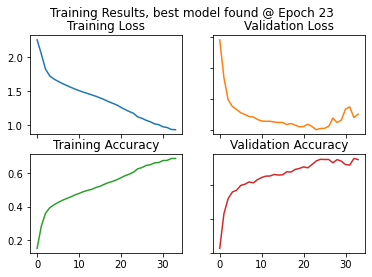

In [71]:
plot_results(s1)

### Checking Accuracy of Best Model

In [72]:
# Loading new best model found:
s1 = Net.load_model("model/step1")
s1.test_network(train_set, "train data")
s1.test_network(valid_set, "valid data")
s1.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 63.37%
Total Count:  40000
Total Match:  25346
-------------------------------------------
Test Accuracy of	0: 73.57% (2964/4029)
Test Accuracy of	1: 38.42% (1545/4021)
Test Accuracy of	2: 40.20% (1601/3983)
Test Accuracy of	3: 44.94% (1777/3954)
Test Accuracy of	4: 52.33% (2097/4007)
Test Accuracy of	5: 77.72% (3132/4030)
Test Accuracy of	6: 73.46% (2975/4050)
Test Accuracy of	7: 80.77% (3213/3978)
Test Accuracy of	8: 77.81% (3100/3984)
Test Accuracy of	9: 74.22% (2942/3964)
-------------------------------------------
Accuracy on valid data: 47.05%
Total Count:  10000
Total Match:  4705
-------------------------------------------
Test Accuracy of	0: 55.82% (542/971)
Test Accuracy of	1: 23.60% (231/979)
Test Accuracy of	2: 24.19% (246/1017)
Test Accuracy of	3: 30.50% (319/1046)
Test Accuracy of	4: 37.46% (372/993)
Test Accuracy of	5: 62.37% (605/970)
Test Accuracy of	6: 54.21% (515/950)
Test Accuracy of	7: 68.79% (703/

## Model Variation 3B: Step Decay of LR (step = 25, drop = 0.95)

In [73]:
# train model till convergence
s2 = step2.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:02<04:40,  2.83s/it]

Epoch: 0	Interval Time: 2.8 sec(s)	Training Loss: 2.250235		Training Accuracy: 0.164775
						Validation Loss:2.167961	Validation Accuracy: 0.224300


 11%|███████████████▍                                                                                                                            | 11/100 [00:32<04:31,  3.05s/it]

Epoch: 10	Interval Time: 30.2 sec(s)	Training Loss: 1.530673		Training Accuracy: 0.473350
						Validation Loss:1.675374	Validation Accuracy: 0.420200


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:02<03:48,  2.90s/it]

Epoch: 20	Interval Time: 29.0 sec(s)	Training Loss: 1.257510		Training Accuracy: 0.575425
						Validation Loss:1.644136	Validation Accuracy: 0.448400


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [01:30<03:14,  2.82s/it]

Epoch: 30	Interval Time: 28.5 sec(s)	Training Loss: 0.963581		Training Accuracy: 0.677625
						Validation Loss:1.776358	Validation Accuracy: 0.453300


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [01:33<03:27,  3.01s/it]



Minimum percent change (1e-25%) in training loss not exceeded.

Convergence criteria achieved.
Training completed @ Epoch 31.
Total training time: 1 min 33.3 s

                Best model found @ Epoch 21
                --------------------------------------------
                Training Loss: 1.230658
                Validation Loss: 1.608741
                --------------------------------------------
                Training Accuracy: 0.583850
                Validation Accuracy: 0.458300


Best model 'step2' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

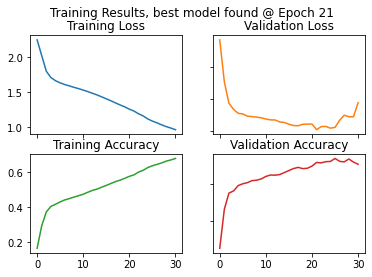

In [74]:
plot_results(s2)

### Checking Accuracy of Best Model

In [75]:
# Loading new best model found:
s2 = Net.load_model("model/step2")
s2.test_network(train_set, "train data")
s2.test_network(valid_set, "valid data")
s2.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 61.44%
Total Count:  40000
Total Match:  24577
-------------------------------------------
Test Accuracy of	0: 70.56% (2843/4029)
Test Accuracy of	1: 36.11% (1452/4021)
Test Accuracy of	2: 52.95% (2109/3983)
Test Accuracy of	3: 35.71% (1412/3954)
Test Accuracy of	4: 41.45% (1661/4007)
Test Accuracy of	5: 76.43% (3080/4030)
Test Accuracy of	6: 73.31% (2969/4050)
Test Accuracy of	7: 79.89% (3178/3978)
Test Accuracy of	8: 75.58% (3011/3984)
Test Accuracy of	9: 72.20% (2862/3964)
-------------------------------------------
Accuracy on valid data: 45.83%
Total Count:  10000
Total Match:  4583
-------------------------------------------
Test Accuracy of	0: 53.45% (519/971)
Test Accuracy of	1: 22.88% (224/979)
Test Accuracy of	2: 35.40% (360/1017)
Test Accuracy of	3: 26.20% (274/1046)
Test Accuracy of	4: 30.61% (304/993)
Test Accuracy of	5: 57.22% (555/970)
Test Accuracy of	6: 52.32% (497/950)
Test Accuracy of	7: 66.93% (684/

# ITERATION 5: DECISION
## Reset to no Learning Rate decay, based on Accuracy Result on Test Set.

# ITERATION 6: L2 Regularization

## Model Variation 1: L2_reg_term = 0.04

In [96]:
# Initializing model hyper-parameters
l24 = Net(
    optimizer = SGD(
        learning_rate= 0.05,  
        weight_decay = 0.005,
        momentum = 0.999, 
        lr_decay = "default"  
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,  # batch_norm now set to True, uses default alpha scalar of 0.9
    L2_reg_term = 0.04
)

# Adding Layers (and setting Layer hyper-parameters)
l24.add(Linear(128, 1024))
l24.add(ReLU())
l24.add(Linear(1024, 512))                                  
l24.add(ReLU())
l24.add(Linear(512, 64)) 
l24.add(ReLU())
l24.add(Linear(64, 10))

l24.set_name("l24")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 2: L2_reg_term = 0.02

In [97]:
# Initializing model hyper-parameters
l22 = Net(
    optimizer = SGD(
        learning_rate= 0.05,  
        weight_decay = 0.005,
        momentum = 0.999, 
        lr_decay = "default" 
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,  # batch_norm now set to True, uses default alpha scalar of 0.9
    L2_reg_term = 0.02
)

# Adding Layers (and setting Layer hyper-parameters)
l22.add(Linear(128, 1024))
l22.add(ReLU())
l22.add(Linear(1024, 512))                                  
l22.add(ReLU())
l22.add(Linear(512, 64)) 
l22.add(ReLU())
l22.add(Linear(64, 10))

l22.set_name("l22")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 3: L2_reg_term = 0.01

In [100]:
# Initializing model hyper-parameters
l21 = Net(
    optimizer = SGD(
        learning_rate= 0.05,  
        weight_decay = 0.005,
        momentum = 0.999, 
        lr_decay = "default"  
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,  # batch_norm now set to True, uses default alpha scalar of 0.9
    L2_reg_term = 0.01
)

# Adding Layers (and setting Layer hyper-parameters)
l21.add(Linear(128, 1024))
l21.add(ReLU())
l21.add(Linear(1024, 512))                                  
l21.add(ReLU())
l21.add(Linear(512, 64)) 
l21.add(ReLU())
l21.add(Linear(64, 10))

l21.set_name("l21")  # creates name for model for loading saved model from training (with min val loss)

# ITERATION 6: TRAINING

## Model Variation 1: L2_reg_term = 0.04

In [99]:
# train model till convergence
l24s = l24.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:03<05:00,  3.03s/it]

Epoch: 0	Interval Time: 3.0 sec(s)	Training Loss: 2.254800		Training Accuracy: 0.154250
						Validation Loss:2.184024	Validation Accuracy: 0.214300


 11%|███████████████▍                                                                                                                            | 11/100 [00:34<04:33,  3.07s/it]

Epoch: 10	Interval Time: 31.0 sec(s)	Training Loss: 1.564125		Training Accuracy: 0.460925
						Validation Loss:1.693669	Validation Accuracy: 0.409200


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:05<04:07,  3.13s/it]

Epoch: 20	Interval Time: 31.3 sec(s)	Training Loss: 1.358848		Training Accuracy: 0.540025
						Validation Loss:1.645938	Validation Accuracy: 0.440700


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [01:37<03:37,  3.15s/it]

Epoch: 30	Interval Time: 32.0 sec(s)	Training Loss: 1.053820		Training Accuracy: 0.650875
						Validation Loss:1.606414	Validation Accuracy: 0.483100


 32%|████████████████████████████████████████████▊                                                                                               | 32/100 [01:44<03:42,  3.27s/it]



Minimum percent change (1e-25%) in training loss not exceeded.

Convergence criteria achieved.
Training completed @ Epoch 32.
Total training time: 1 min 44.6 s

                Best model found @ Epoch 27
                --------------------------------------------
                Training Loss: 1.119399
                Validation Loss: 1.575748
                --------------------------------------------
                Training Accuracy: 0.626600
                Validation Accuracy: 0.480700


Best model 'l24' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

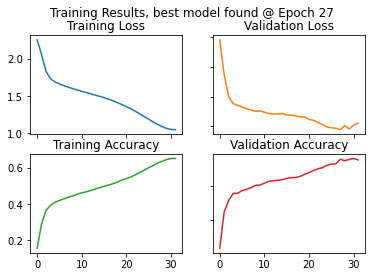

In [101]:
plot_results(l24s)

### Checking Accuracy of Best Model

In [102]:
# Loading new best model found:
l24 = Net.load_model("model/l24")
l24.test_network(train_set, "train data")
l24.test_network(valid_set, "valid data")
l24.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 65.70%
Total Count:  40000
Total Match:  26280
-------------------------------------------
Test Accuracy of	0: 72.38% (2916/4029)
Test Accuracy of	1: 44.76% (1800/4021)
Test Accuracy of	2: 50.67% (2018/3983)
Test Accuracy of	3: 44.61% (1764/3954)
Test Accuracy of	4: 58.05% (2326/4007)
Test Accuracy of	5: 75.16% (3029/4030)
Test Accuracy of	6: 78.62% (3184/4050)
Test Accuracy of	7: 85.85% (3415/3978)
Test Accuracy of	8: 75.08% (2991/3984)
Test Accuracy of	9: 71.57% (2837/3964)
-------------------------------------------
Accuracy on valid data: 48.07%
Total Count:  10000
Total Match:  4807
-------------------------------------------
Test Accuracy of	0: 55.30% (537/971)
Test Accuracy of	1: 25.84% (253/979)
Test Accuracy of	2: 32.35% (329/1017)
Test Accuracy of	3: 32.22% (337/1046)
Test Accuracy of	4: 42.40% (421/993)
Test Accuracy of	5: 55.57% (539/970)
Test Accuracy of	6: 57.05% (542/950)
Test Accuracy of	7: 74.07% (757/

## Model Variation 2: L2_reg_term = 0.07

In [82]:
# train model till convergence
l27s = l27.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:03<05:18,  3.22s/it]

Epoch: 0	Interval Time: 3.2 sec(s)	Training Loss: 2.256942		Training Accuracy: 0.157950
						Validation Loss:2.186213	Validation Accuracy: 0.211200


 11%|███████████████▍                                                                                                                            | 11/100 [00:35<04:48,  3.25s/it]

Epoch: 10	Interval Time: 32.4 sec(s)	Training Loss: 1.570067		Training Accuracy: 0.459475
						Validation Loss:1.693635	Validation Accuracy: 0.412100


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:09<04:22,  3.33s/it]

Epoch: 20	Interval Time: 34.1 sec(s)	Training Loss: 1.335476		Training Accuracy: 0.543900
						Validation Loss:1.637439	Validation Accuracy: 0.441100


 29%|████████████████████████████████████████▌                                                                                                   | 29/100 [01:38<04:01,  3.40s/it]



Minimum percent change (1e-25%) in training loss not exceeded.

Convergence criteria achieved.
Training completed @ Epoch 29.
Total training time: 1 min 38.5 s

                Best model found @ Epoch 23
                --------------------------------------------
                Training Loss: 1.243980
                Validation Loss: 1.600943
                --------------------------------------------
                Training Accuracy: 0.577000
                Validation Accuracy: 0.458100


Best model 'l27' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

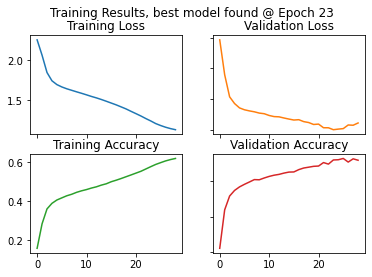

In [83]:
plot_results(l27s)

### Checking Accuracy of Best Model

In [84]:
# Loading new best model found:
l27 = Net.load_model("model/l27")
l27.test_network(train_set, "train data")
l27.test_network(valid_set, "valid data")
l27.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 59.70%
Total Count:  40000
Total Match:  23879
-------------------------------------------
Test Accuracy of	0: 63.12% (2543/4029)
Test Accuracy of	1: 41.93% (1686/4021)
Test Accuracy of	2: 38.89% (1549/3983)
Test Accuracy of	3: 27.85% (1101/3954)
Test Accuracy of	4: 52.33% (2097/4007)
Test Accuracy of	5: 75.48% (3042/4030)
Test Accuracy of	6: 74.20% (3005/4050)
Test Accuracy of	7: 84.21% (3350/3978)
Test Accuracy of	8: 78.41% (3124/3984)
Test Accuracy of	9: 60.09% (2382/3964)
-------------------------------------------
Accuracy on valid data: 45.81%
Total Count:  10000
Total Match:  4581
-------------------------------------------
Test Accuracy of	0: 49.02% (476/971)
Test Accuracy of	1: 25.64% (251/979)
Test Accuracy of	2: 24.88% (253/1017)
Test Accuracy of	3: 21.13% (221/1046)
Test Accuracy of	4: 40.28% (400/993)
Test Accuracy of	5: 60.62% (588/970)
Test Accuracy of	6: 54.95% (522/950)
Test Accuracy of	7: 75.15% (768/

## Model Variation 3: L2_reg_term = 0.1

In [85]:
# train model till convergence
l21s = l21.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:03<05:16,  3.19s/it]

Epoch: 0	Interval Time: 3.2 sec(s)	Training Loss: 2.261535		Training Accuracy: 0.153425
						Validation Loss:2.191124	Validation Accuracy: 0.217500


 11%|███████████████▍                                                                                                                            | 11/100 [00:36<05:04,  3.43s/it]

Epoch: 10	Interval Time: 32.9 sec(s)	Training Loss: 1.554399		Training Accuracy: 0.462775
						Validation Loss:1.688551	Validation Accuracy: 0.414900


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:08<04:15,  3.24s/it]

Epoch: 20	Interval Time: 32.3 sec(s)	Training Loss: 1.344062		Training Accuracy: 0.539850
						Validation Loss:1.646758	Validation Accuracy: 0.440700


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [01:42<04:02,  3.52s/it]

Epoch: 30	Interval Time: 34.4 sec(s)	Training Loss: 1.072460		Training Accuracy: 0.640050
						Validation Loss:1.646061	Validation Accuracy: 0.463600


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [01:46<03:56,  3.42s/it]



Minimum percent change (1e-25%) in training loss not exceeded.

Convergence criteria achieved.
Training completed @ Epoch 31.
Total training time: 1 min 46.1 s

                Best model found @ Epoch 27
                --------------------------------------------
                Training Loss: 1.125182
                Validation Loss: 1.595427
                --------------------------------------------
                Training Accuracy: 0.622025
                Validation Accuracy: 0.471600


Best model 'l21' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

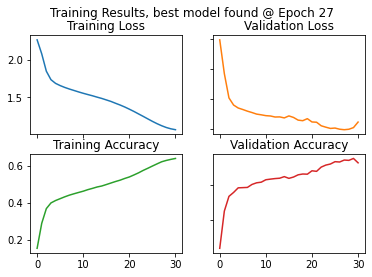

In [86]:
plot_results(l21s)

### Checking Accuracy of Best Model

In [87]:
# Loading new best model found:
l21 = Net.load_model("model/l21")
l21.test_network(train_set, "train data")
l21.test_network(valid_set, "valid data")
l21.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 63.84%
Total Count:  40000
Total Match:  25538
-------------------------------------------
Test Accuracy of	0: 79.87% (3218/4029)
Test Accuracy of	1: 35.24% (1417/4021)
Test Accuracy of	2: 45.67% (1819/3983)
Test Accuracy of	3: 47.37% (1873/3954)
Test Accuracy of	4: 44.92% (1800/4007)
Test Accuracy of	5: 80.89% (3260/4030)
Test Accuracy of	6: 79.09% (3203/4050)
Test Accuracy of	7: 80.69% (3210/3978)
Test Accuracy of	8: 69.48% (2768/3984)
Test Accuracy of	9: 74.92% (2970/3964)
-------------------------------------------
Accuracy on valid data: 47.16%
Total Count:  10000
Total Match:  4716
-------------------------------------------
Test Accuracy of	0: 64.06% (622/971)
Test Accuracy of	1: 20.63% (202/979)
Test Accuracy of	2: 30.29% (308/1017)
Test Accuracy of	3: 34.89% (365/1046)
Test Accuracy of	4: 30.31% (301/993)
Test Accuracy of	5: 59.79% (580/970)
Test Accuracy of	6: 57.89% (550/950)
Test Accuracy of	7: 67.22% (687/

# ITERATION 6: Exploring possible combinations

## Model Variation 1: Dropout = 0.2 each layer,  Batch-Norm & Step-Decay (on current model)

In [112]:
# Initializing model hyper-parameters
do2 = Net(
    optimizer = SGD(
        learning_rate= 0.05,  # default LR set
        weight_decay = 0.003,
        momentum = 0.999,
        lr_decay = "step",
        step_terms = (25, 0.95)
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = True,
    L2_reg_term = 0.004
)

# Adding Layers (and setting Layer hyper-parameters)
do2.add(Linear(128, 1024, dropout = 0.2))  # Applying dropout = 0.2 all layers besides last
do2.add(ReLU())
do2.add(Linear(1024, 512, dropout = 0.2))                                  
do2.add(ReLU())
do2.add(Linear(512, 64, dropout = 0.2)) 
do2.add(ReLU())
do2.add(Linear(64, 10))

do2.set_name("do2")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 2: Dropout = 0.4 each layer, no LR decay, Batch-Norm

In [118]:
# Initializing model hyper-parameters
do4 = Net(
    optimizer = SGD(
        learning_rate= 0.05,  # default LR set
        weight_decay = 0.003,
        momentum = 0.999,
        lr_decay = "default"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = True,
    L2_reg_term = 0.04
)

# Adding Layers (and setting Layer hyper-parameters)
do4.add(Linear(128, 1024, dropout = 0.4))  # Applying dropout = 0.4 all layers besides last 
do4.add(ReLU())
do4.add(Linear(1024, 512, dropout = 0.4))                                  
do4.add(ReLU())
do4.add(Linear(512, 64, dropout = 0.4)) 
do4.add(ReLU())
do4.add(Linear(64, 10))

do4.set_name("do4")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 3: Dropout = Mix, Step-decay, Batch-Norm

In [117]:
# Initializing model hyper-parameters
do_mix = Net(
    optimizer = SGD(
        learning_rate= 0.05,  # default LR set
        weight_decay = 0.003,
        momentum = 0.999,
        lr_decay = "default"
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = False,
    L2_reg_term = 0.004
)

# Adding Layers (and setting Layer hyper-parameters)
do_mix.add(Linear(128, 1024, dropout = 0.4))  # Applying dropout = 0.4
do_mix.add(ReLU())
do_mix.add(Linear(1024, 512, dropout = 0.2))     # Applying dropout = 0.2                            
do_mix.add(ReLU())
do_mix.add(Linear(512, 64))     
do_mix.add(ReLU())
do_mix.add(Linear(64, 10))

do_mix.set_name("do_mix")  # creates name for model for loading saved model from training (with min val loss)

## Model Variation 1: Dropout = 0.2 each layer,  Batch-Norm & Step-Decay (on current model)

In [113]:
# train model till convergence
do2_stats = do2.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:06<10:24,  6.31s/it]

Epoch: 0	Interval Time: 6.3 sec(s)	Training Loss: 2.273453		Training Accuracy: 0.203925
						Validation Loss:1.893826	Validation Accuracy: 0.338300


 11%|███████████████▍                                                                                                                            | 11/100 [01:16<09:49,  6.62s/it]

Epoch: 10	Interval Time: 1 min 9.7 s	Training Loss: 1.548625		Training Accuracy: 0.474850
						Validation Loss:1.548810	Validation Accuracy: 0.475000


 21%|█████████████████████████████▍                                                                                                              | 21/100 [02:19<08:30,  6.46s/it]

Epoch: 20	Interval Time: 1 min 3.5 s	Training Loss: 1.387742		Training Accuracy: 0.547925
						Validation Loss:1.443872	Validation Accuracy: 0.517800


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [03:30<07:32,  6.56s/it]

Epoch: 30	Interval Time: 1 min 10.7 s	Training Loss: 1.256453		Training Accuracy: 0.611400
						Validation Loss:1.377557	Validation Accuracy: 0.547100


 41%|█████████████████████████████████████████████████████████▍                                                                                  | 41/100 [04:31<05:59,  6.09s/it]

Epoch: 40	Interval Time: 1 min 1.4 s	Training Loss: 1.152840		Training Accuracy: 0.660700
						Validation Loss:1.341370	Validation Accuracy: 0.561000


 51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 51/100 [05:32<04:56,  6.06s/it]

Epoch: 50	Interval Time: 1 min 0.5 s	Training Loss: 1.069121		Training Accuracy: 0.700775
						Validation Loss:1.326773	Validation Accuracy: 0.572100


 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                      | 61/100 [06:35<04:07,  6.35s/it]

Epoch: 60	Interval Time: 1 min 2.9 s	Training Loss: 1.005420		Training Accuracy: 0.728200
						Validation Loss:1.326152	Validation Accuracy: 0.574600


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 70/100 [07:37<03:15,  6.53s/it]

Epoch: 70	Interval Time: 1 min 2.3 s	Training Loss: 0.950574		Training Accuracy: 0.757200
						Validation Loss:1.329035	Validation Accuracy: 0.574600


No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 70.
Total training time: 7 min 37.3 s

                Best model found @ Epoch 59
                --------------------------------------------
                Training Loss: 1.012305
                Validation Loss: 1.322325
                --------------------------------------------
                Training Accuracy: 0.727600
                Validation Accuracy: 0.574400


Best model 'do2' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

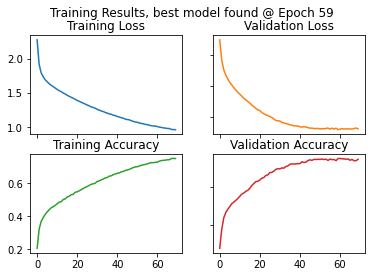

In [114]:
plot_results(do2_stats)

### Checking Accuracy of Best Model

In [115]:
# Loading new best model found:
do2 = Net.load_model("model/do2")
do2.test_network(train_set, "train data")
do2.test_network(valid_set, "valid data")
do2.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 87.91%
Total Count:  40000
Total Match:  35165
-------------------------------------------
Test Accuracy of	0: 91.88% (3702/4029)
Test Accuracy of	1: 85.87% (3453/4021)
Test Accuracy of	2: 80.52% (3207/3983)
Test Accuracy of	3: 87.73% (3469/3954)
Test Accuracy of	4: 83.18% (3333/4007)
Test Accuracy of	5: 89.83% (3620/4030)
Test Accuracy of	6: 89.83% (3638/4050)
Test Accuracy of	7: 92.03% (3661/3978)
Test Accuracy of	8: 91.67% (3652/3984)
Test Accuracy of	9: 86.53% (3430/3964)
-------------------------------------------
Accuracy on valid data: 57.44%
Total Count:  10000
Total Match:  5744
-------------------------------------------
Test Accuracy of	0: 66.32% (644/971)
Test Accuracy of	1: 44.64% (437/979)
Test Accuracy of	2: 38.64% (393/1017)
Test Accuracy of	3: 54.40% (569/1046)
Test Accuracy of	4: 45.22% (449/993)
Test Accuracy of	5: 64.33% (624/970)
Test Accuracy of	6: 59.26% (563/950)
Test Accuracy of	7: 72.02% (736/

## Model Variation 2: Dropout = 0.4 each layer, no LR decay, Batch-Norm

In [119]:
# train model till convergence
do4_stats = do4.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:06<11:02,  6.69s/it]

Epoch: 0	Interval Time: 6.7 sec(s)	Training Loss: 2.450108		Training Accuracy: 0.149600
						Validation Loss:2.046731	Validation Accuracy: 0.253600


 11%|███████████████▍                                                                                                                            | 11/100 [01:20<10:51,  7.32s/it]

Epoch: 10	Interval Time: 1 min 14.1 s	Training Loss: 1.755153		Training Accuracy: 0.379250
						Validation Loss:1.681167	Validation Accuracy: 0.425700


 21%|█████████████████████████████▍                                                                                                              | 21/100 [02:27<08:42,  6.62s/it]

Epoch: 20	Interval Time: 1 min 6.8 s	Training Loss: 1.642006		Training Accuracy: 0.430225
						Validation Loss:1.578640	Validation Accuracy: 0.461000


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [03:35<07:43,  6.72s/it]

Epoch: 30	Interval Time: 1 min 8.0 s	Training Loss: 1.559057		Training Accuracy: 0.466525
						Validation Loss:1.500947	Validation Accuracy: 0.487500


 41%|█████████████████████████████████████████████████████████▍                                                                                  | 41/100 [04:40<06:21,  6.47s/it]

Epoch: 40	Interval Time: 1 min 4.8 s	Training Loss: 1.474890		Training Accuracy: 0.505875
						Validation Loss:1.430113	Validation Accuracy: 0.513000


 51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 51/100 [05:46<05:24,  6.62s/it]

Epoch: 50	Interval Time: 1 min 6.5 s	Training Loss: 1.402539		Training Accuracy: 0.537275
						Validation Loss:1.375909	Validation Accuracy: 0.540700


 57%|███████████████████████████████████████████████████████████████████████████████▊                                                            | 57/100 [06:33<04:56,  6.90s/it]



Minimum percent change (1e-25%) in training loss not exceeded.

Convergence criteria achieved.
Training completed @ Epoch 57.
Total training time: 6 min 33.5 s

                Best model found @ Epoch 57
                --------------------------------------------
                Training Loss: 1.357618
                Validation Loss: 1.349753
                --------------------------------------------
                Training Accuracy: 0.557475
                Validation Accuracy: 0.550500


Best model 'do4' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss & Accuracy Curves

<Figure size 720x504 with 0 Axes>

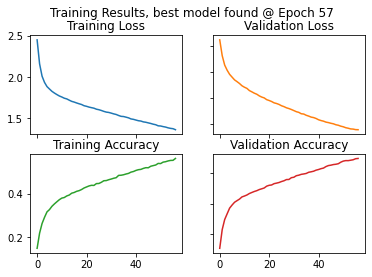

In [120]:
plot_results(do4_stats)

### Checking Accuracy of Best Model

In [121]:
# Loading new best model found:
do4 = Net.load_model("model/do4")
do4.test_network(train_set, "train data")
do4.test_network(valid_set, "valid data")
do4.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 67.44%
Total Count:  40000
Total Match:  26977
-------------------------------------------
Test Accuracy of	0: 80.02% (3224/4029)
Test Accuracy of	1: 55.66% (2238/4021)
Test Accuracy of	2: 41.63% (1658/3983)
Test Accuracy of	3: 66.29% (2621/3954)
Test Accuracy of	4: 52.33% (2097/4007)
Test Accuracy of	5: 78.73% (3173/4030)
Test Accuracy of	6: 73.04% (2958/4050)
Test Accuracy of	7: 81.98% (3261/3978)
Test Accuracy of	8: 73.37% (2923/3984)
Test Accuracy of	9: 71.24% (2824/3964)
-------------------------------------------
Accuracy on valid data: 55.05%
Total Count:  10000
Total Match:  5505
-------------------------------------------
Test Accuracy of	0: 67.56% (656/971)
Test Accuracy of	1: 39.63% (388/979)
Test Accuracy of	2: 29.40% (299/1017)
Test Accuracy of	3: 53.25% (557/1046)
Test Accuracy of	4: 41.39% (411/993)
Test Accuracy of	5: 66.39% (644/970)
Test Accuracy of	6: 57.79% (549/950)
Test Accuracy of	7: 73.87% (755/

## Model Variation 3: Dropout = mix, Step-decay, Batch-Norm

In [122]:
# train model till convergence
do_mix_stats = do_mix.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:04<07:31,  4.56s/it]

Epoch: 0	Interval Time: 4.5 sec(s)	Training Loss: 2.303536		Training Accuracy: 0.122025
						Validation Loss:2.242027	Validation Accuracy: 0.164300


 11%|███████████████▍                                                                                                                            | 11/100 [00:52<07:28,  5.04s/it]

Epoch: 10	Interval Time: 48.2 sec(s)	Training Loss: 1.735805		Training Accuracy: 0.384750
						Validation Loss:1.721320	Validation Accuracy: 0.389800


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:41<06:02,  4.58s/it]

Epoch: 20	Interval Time: 48.7 sec(s)	Training Loss: 1.682089		Training Accuracy: 0.419575
						Validation Loss:1.721060	Validation Accuracy: 0.403600


 21%|█████████████████████████████▍                                                                                                              | 21/100 [01:45<06:38,  5.04s/it]



Minimum percent change (1e-25%) in training loss not exceeded.

Convergence criteria achieved.
Training completed @ Epoch 21.
Total training time: 1 min 45.9 s

                Best model found @ Epoch 14
                --------------------------------------------
                Training Loss: 1.704729
                Validation Loss: 1.712793
                --------------------------------------------
                Training Accuracy: 0.400825
                Validation Accuracy: 0.397400


Best model 'do_mix' saved in 'model/' directory.


{'tags': ['hide-output']}

# ITERATION 6: DECISION
## Explore Model Variation 1

In [124]:
# Initializing model hyper-parameters
x = Net(
    optimizer = SGD(
        learning_rate= 0.05,  # tweaking parameters
        weight_decay = 0.001,
        momentum = 0.999,
        lr_decay = "step",
        step_terms = (25, 0.85)  
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = True,
    L2_reg_term = 0.002
)

# Adding Layers (and setting Layer hyper-parameters)
x.add(Linear(128, 1024, dropout = 0.2))  # Applying dropout = 0.2 all layers besides last
x.add(ReLU())
x.add(Linear(1024, 512, dropout = 0.2))                                  
x.add(ReLU())
x.add(Linear(512, 64, dropout = 0.2)) 
x.add(ReLU())
x.add(Linear(64, 10))

x.set_name("x")  # creates name for model for loading saved model from training (with min val loss)

## Train

In [125]:
# train model till convergence
xs = x.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:06<10:12,  6.19s/it]

Epoch: 0	Interval Time: 6.2 sec(s)	Training Loss: 2.240572		Training Accuracy: 0.211350
						Validation Loss:1.879036	Validation Accuracy: 0.335200


 11%|███████████████▍                                                                                                                            | 11/100 [01:10<09:27,  6.38s/it]

Epoch: 10	Interval Time: 1 min 4.3 s	Training Loss: 1.572025		Training Accuracy: 0.468150
						Validation Loss:1.565194	Validation Accuracy: 0.467000


 21%|█████████████████████████████▍                                                                                                              | 21/100 [02:15<08:50,  6.71s/it]

Epoch: 20	Interval Time: 1 min 5.4 s	Training Loss: 1.429988		Training Accuracy: 0.529875
						Validation Loss:1.470800	Validation Accuracy: 0.506800


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [03:20<07:50,  6.82s/it]

Epoch: 30	Interval Time: 1 min 4.8 s	Training Loss: 1.331613		Training Accuracy: 0.576825
						Validation Loss:1.411433	Validation Accuracy: 0.534500


 41%|█████████████████████████████████████████████████████████▍                                                                                  | 41/100 [04:27<06:24,  6.51s/it]

Epoch: 40	Interval Time: 1 min 6.3 s	Training Loss: 1.252074		Training Accuracy: 0.615650
						Validation Loss:1.375372	Validation Accuracy: 0.550800


 51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 51/100 [05:28<04:56,  6.05s/it]

Epoch: 50	Interval Time: 1 min 1.0 s	Training Loss: 1.188652		Training Accuracy: 0.642825
						Validation Loss:1.351850	Validation Accuracy: 0.566800


 54%|███████████████████████████████████████████████████████████████████████████▌                                                                | 54/100 [05:52<05:00,  6.53s/it]



Minimum percent change (1e-25%) in training loss not exceeded.

Convergence criteria achieved.
Training completed @ Epoch 54.
Total training time: 5 min 52.5 s

                Best model found @ Epoch 54
                --------------------------------------------
                Training Loss: 1.167696
                Validation Loss: 1.346493
                --------------------------------------------
                Training Accuracy: 0.656075
                Validation Accuracy: 0.569600


Best model 'x' saved in 'model/' directory.


{'tags': ['hide-output']}

## Results

<Figure size 720x504 with 0 Axes>

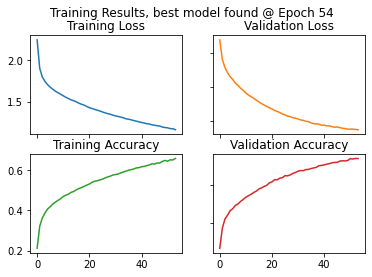

-------------------------------------------
Accuracy on train data: 78.22%
Total Count:  40000
Total Match:  31289
-------------------------------------------
Test Accuracy of	0: 84.16% (3391/4029)
Test Accuracy of	1: 69.46% (2793/4021)
Test Accuracy of	2: 69.32% (2761/3983)
Test Accuracy of	3: 75.37% (2980/3954)
Test Accuracy of	4: 67.16% (2691/4007)
Test Accuracy of	5: 84.62% (3410/4030)
Test Accuracy of	6: 81.38% (3296/4050)
Test Accuracy of	7: 88.31% (3513/3978)
Test Accuracy of	8: 85.12% (3391/3984)
Test Accuracy of	9: 77.27% (3063/3964)
-------------------------------------------
Accuracy on valid data: 56.96%
Total Count:  10000
Total Match:  5696
-------------------------------------------
Test Accuracy of	0: 63.95% (621/971)
Test Accuracy of	1: 42.29% (414/979)
Test Accuracy of	2: 40.31% (410/1017)
Test Accuracy of	3: 53.54% (560/1046)
Test Accuracy of	4: 44.41% (441/993)
Test Accuracy of	5: 64.23% (623/970)
Test Accuracy of	6: 60.63% (576/950)
Test Accuracy of	7: 73.19% (748/

In [126]:
plot_results(xs)

# Loading new best model found:
x = Net.load_model("model/x")
x.test_network(train_set, "train data")
x.test_network(valid_set, "valid data")
x.test_network(test_set, "test data")

## Model Variation 

In [128]:
# Initializing model hyper-parameters
x1 = Net(
    optimizer = SGD(
        learning_rate= 0.04,  # tweaking parameters
        weight_decay = 0.004,
        momentum = 0.999,
        lr_decay = "step",
        step_terms = (25, 0.95)  
    ),
    criterion = CrossEntropyLoss(),
    batch_norm = True,
    L2_reg_term = 0.001
)

# Adding Layers (and setting Layer hyper-parameters)
x1.add(Linear(128, 1024, dropout = 0.2))  # Applying dropout = 0.2 all layers besides last
x1.add(ReLU())
x1.add(Linear(1024, 512, dropout = 0.2))                                  
x1.add(ReLU())
x1.add(Linear(512, 64)) 
x1.add(ReLU())
x1.add(Linear(64, 10))

x1.set_name("x1")  # creates name for model for loading saved model from training (with min val loss)

In [129]:
# train model till convergence
x1s = x1.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:06<10:41,  6.48s/it]

Epoch: 0	Interval Time: 6.5 sec(s)	Training Loss: 2.227393		Training Accuracy: 0.218600
						Validation Loss:1.890901	Validation Accuracy: 0.322600


 11%|███████████████▍                                                                                                                            | 11/100 [01:13<09:48,  6.61s/it]

Epoch: 10	Interval Time: 1 min 6.7 s	Training Loss: 1.510318		Training Accuracy: 0.496125
						Validation Loss:1.548813	Validation Accuracy: 0.473200


 21%|█████████████████████████████▍                                                                                                              | 21/100 [02:15<08:10,  6.21s/it]

Epoch: 20	Interval Time: 1 min 2.8 s	Training Loss: 1.336978		Training Accuracy: 0.574700
						Validation Loss:1.439900	Validation Accuracy: 0.519100


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [03:26<07:42,  6.71s/it]

Epoch: 30	Interval Time: 1 min 10.1 s	Training Loss: 1.206842		Training Accuracy: 0.637950
						Validation Loss:1.379008	Validation Accuracy: 0.546800


 41%|█████████████████████████████████████████████████████████▍                                                                                  | 41/100 [04:30<06:01,  6.13s/it]

Epoch: 40	Interval Time: 1 min 4.1 s	Training Loss: 1.089760		Training Accuracy: 0.693650
						Validation Loss:1.349921	Validation Accuracy: 0.565500


 51%|███████████████████████████████████████████████████████████████████████▍                                                                    | 51/100 [05:30<04:55,  6.02s/it]

Epoch: 50	Interval Time: 1 min 0.7 s	Training Loss: 1.004860		Training Accuracy: 0.735700
						Validation Loss:1.338375	Validation Accuracy: 0.568600


 61%|█████████████████████████████████████████████████████████████████████████████████████▍                                                      | 61/100 [06:31<03:55,  6.03s/it]

Epoch: 60	Interval Time: 1 min 0.9 s	Training Loss: 0.938063		Training Accuracy: 0.766350
						Validation Loss:1.332251	Validation Accuracy: 0.569400


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 71/100 [07:37<03:18,  6.83s/it]

Epoch: 70	Interval Time: 1 min 6.0 s	Training Loss: 0.887641		Training Accuracy: 0.790225
						Validation Loss:1.335197	Validation Accuracy: 0.568100


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 75/100 [08:14<02:44,  6.59s/it]



No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 75.
Total training time: 8 min 14.5 s

                Best model found @ Epoch 64
                --------------------------------------------
                Training Loss: 0.916297
                Validation Loss: 1.328113
                --------------------------------------------
                Training Accuracy: 0.776325
                Validation Accuracy: 0.574600


Best model 'x1' saved in 'model/' directory.


{'tags': ['hide-output']}

<Figure size 720x504 with 0 Axes>

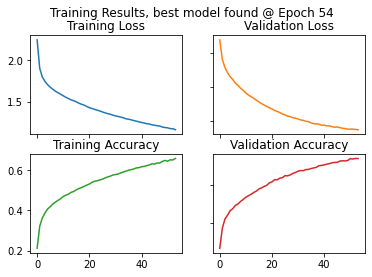

-------------------------------------------
Accuracy on train data: 91.05%
Total Count:  40000
Total Match:  36418
-------------------------------------------
Test Accuracy of	0: 94.29% (3799/4029)
Test Accuracy of	1: 86.07% (3461/4021)
Test Accuracy of	2: 86.74% (3455/3983)
Test Accuracy of	3: 92.19% (3645/3954)
Test Accuracy of	4: 88.84% (3560/4007)
Test Accuracy of	5: 94.17% (3795/4030)
Test Accuracy of	6: 90.40% (3661/4050)
Test Accuracy of	7: 92.84% (3693/3978)
Test Accuracy of	8: 92.44% (3683/3984)
Test Accuracy of	9: 92.48% (3666/3964)
-------------------------------------------
Accuracy on valid data: 57.46%
Total Count:  10000
Total Match:  5746
-------------------------------------------
Test Accuracy of	0: 70.24% (682/971)
Test Accuracy of	1: 40.65% (398/979)
Test Accuracy of	2: 34.22% (348/1017)
Test Accuracy of	3: 55.83% (584/1046)
Test Accuracy of	4: 43.30% (430/993)
Test Accuracy of	5: 67.42% (654/970)
Test Accuracy of	6: 59.58% (566/950)
Test Accuracy of	7: 73.58% (752/

In [130]:
plot_results(xs)

# Loading new best model found:
x1 = Net.load_model("model/x1")
x1.test_network(train_set, "train data")
x1.test_network(valid_set, "valid data")
x1.test_network(test_set, "test data")

# Using Adam Optimizer (default params) on Same Network Architecture

In [149]:
# Initializing model hyper-parameters
adam = Net(
    optimizer = Adam(),
    criterion = CrossEntropyLoss(),
    batch_norm = True,
    L2_reg_term = 0.001
)

# Adding Layers (and setting Layer hyper-parameters)
adam.add(Linear(128, 1024, dropout = 0.2))  # Applying dropout = 0.2 all layers besides last
adam.add(ReLU())
adam.add(Linear(1024, 512, dropout = 0.2))                                  
adam.add(ReLU())
adam.add(Linear(512, 64)) 
adam.add(ReLU())
adam.add(Linear(64, 10))

adam.set_name("adam")  # creates name for model for loading saved model from training (with min val loss)


## TRAINING

In [150]:
# train model till convergence
adam = adam.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 10
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:07<11:42,  7.10s/it]

Epoch: 0	Interval Time: 7.1 sec(s)	Training Loss: 1.853681		Training Accuracy: 0.352650
						Validation Loss:1.608106	Validation Accuracy: 0.445600


 11%|███████████████▍                                                                                                                            | 11/100 [01:28<12:37,  8.51s/it]

Epoch: 10	Interval Time: 1 min 21.8 s	Training Loss: 1.010350		Training Accuracy: 0.726450
						Validation Loss:1.343765	Validation Accuracy: 0.566000


 21%|█████████████████████████████▍                                                                                                              | 21/100 [02:39<09:11,  6.98s/it]

Epoch: 20	Interval Time: 1 min 11.1 s	Training Loss: 0.854030		Training Accuracy: 0.803050
						Validation Loss:1.331845	Validation Accuracy: 0.574500


 25%|███████████████████████████████████                                                                                                         | 25/100 [03:15<09:46,  7.81s/it]



No decrease in validation loss during last 10 epoch(s).

Convergence criteria achieved.
Training completed @ Epoch 25.
Total training time: 3 min 15.4 s

                Best model found @ Epoch 14
                --------------------------------------------
                Training Loss: 0.929028
                Validation Loss: 1.329733
                --------------------------------------------
                Training Accuracy: 0.765575
                Validation Accuracy: 0.571800


Best model 'adam' saved in 'model/' directory.


{'tags': ['hide-output']}

In [153]:
mlp = Net(
    optimizer = Adam(),
    criterion = CrossEntropyLoss(),
    batch_norm = True,
    L2_reg_term = 0.001
)

mlp.add(Linear(128, 1024, dropout=0.4))
mlp.add(ReLU())
mlp.add(Linear(1024, 512, dropout=0.2))
mlp.add(ReLU())
mlp.add(Linear(512, 64, dropout=0.2))
mlp.add(ReLU())
mlp.add(Linear(64, 16, dropout=0.2))
mlp.add(ReLU())
mlp.add(Linear(16, 10))  


mlp.set_name("Adam_network")
print(f"{mlp.model_name} is initialized and ready to be trained.")

Adam_network is initialized and ready to be trained.


### TRAINING TILL CONVERGENCE

In [154]:
stats = mlp.train_convergence(
    train_set = train_set,
    valid_set = valid_set,
    batch_size = 500,
    planned_epochs = 100,
    last_check = 10,
    threshold = 1e-25,
    report_interval = 5
)

{"tags": ["hide-output"]}

  1%|█▍                                                                                                                                           | 1/100 [00:07<12:00,  7.27s/it]

Epoch: 0	Interval Time: 7.2 sec(s)	Training Loss: 2.185345		Training Accuracy: 0.230175
						Validation Loss:1.832465	Validation Accuracy: 0.381100


  6%|████████▍                                                                                                                                    | 6/100 [00:43<11:08,  7.12s/it]

Epoch: 5	Interval Time: 35.8 sec(s)	Training Loss: 1.571227		Training Accuracy: 0.463875
						Validation Loss:1.483312	Validation Accuracy: 0.504100


 11%|███████████████▍                                                                                                                            | 11/100 [01:18<10:38,  7.17s/it]

Epoch: 10	Interval Time: 35.5 sec(s)	Training Loss: 1.419250		Training Accuracy: 0.527225
						Validation Loss:1.381054	Validation Accuracy: 0.543000


 16%|██████████████████████▍                                                                                                                     | 16/100 [01:55<10:18,  7.37s/it]

Epoch: 15	Interval Time: 37.2 sec(s)	Training Loss: 1.333191		Training Accuracy: 0.571575
						Validation Loss:1.338185	Validation Accuracy: 0.562700


 21%|█████████████████████████████▍                                                                                                              | 21/100 [02:30<09:18,  7.07s/it]

Epoch: 20	Interval Time: 35.3 sec(s)	Training Loss: 1.271834		Training Accuracy: 0.602100
						Validation Loss:1.319150	Validation Accuracy: 0.573300


 26%|████████████████████████████████████▍                                                                                                       | 26/100 [03:07<08:56,  7.25s/it]

Epoch: 25	Interval Time: 36.0 sec(s)	Training Loss: 1.224297		Training Accuracy: 0.626950
						Validation Loss:1.306068	Validation Accuracy: 0.576300


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [03:42<08:12,  7.13s/it]

Epoch: 30	Interval Time: 35.5 sec(s)	Training Loss: 1.189270		Training Accuracy: 0.644525
						Validation Loss:1.303303	Validation Accuracy: 0.583100


 31%|███████████████████████████████████████████▍                                                                                                | 31/100 [03:49<08:30,  7.40s/it]



Minimum percent change (1e-25%) in training loss not exceeded.

Convergence criteria achieved.
Training completed @ Epoch 31.
Total training time: 3 min 49.5 s

                Best model found @ Epoch 31
                --------------------------------------------
                Training Loss: 1.195847
                Validation Loss: 1.298740
                --------------------------------------------
                Training Accuracy: 0.640950
                Validation Accuracy: 0.585200


Best model 'Adam_network' saved in 'model/' directory.


{'tags': ['hide-output']}

### Plotting Epoch-wise Loss and Accuracy Curves

<Figure size 720x504 with 0 Axes>

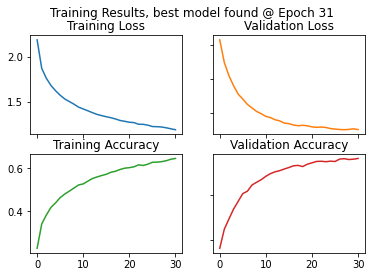

In [155]:
plot_results(stats)

### Checking Accuracy of Best Model Found

In [156]:
# Loading best model found:

best_model = Net.load_model("model/" + mlp.model_name)
best_model.test_network(train_set, "train data")
best_model.test_network(valid_set, "valid data")
best_model.test_network(test_set, "test data")

-------------------------------------------
Accuracy on train data: 81.20%
Total Count:  40000
Total Match:  32482
-------------------------------------------
Test Accuracy of	0: 88.93% (3583/4029)
Test Accuracy of	1: 72.30% (2907/4021)
Test Accuracy of	2: 70.95% (2826/3983)
Test Accuracy of	3: 81.51% (3223/3954)
Test Accuracy of	4: 62.27% (2495/4007)
Test Accuracy of	5: 87.05% (3508/4030)
Test Accuracy of	6: 87.23% (3533/4050)
Test Accuracy of	7: 90.75% (3610/3978)
Test Accuracy of	8: 88.10% (3510/3984)
Test Accuracy of	9: 82.92% (3287/3964)
-------------------------------------------
Accuracy on valid data: 58.52%
Total Count:  10000
Total Match:  5852
-------------------------------------------
Test Accuracy of	0: 70.75% (687/971)
Test Accuracy of	1: 42.39% (415/979)
Test Accuracy of	2: 41.99% (427/1017)
Test Accuracy of	3: 55.45% (580/1046)
Test Accuracy of	4: 37.97% (377/993)
Test Accuracy of	5: 64.85% (629/970)
Test Accuracy of	6: 64.95% (617/950)
Test Accuracy of	7: 78.28% (800/